# Set-up

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Glasgow/Dissertation/Data
! pwd

/content/drive/My Drive/Glasgow/Dissertation/Data
/content/drive/My Drive/Glasgow/Dissertation/Data


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
  
import os
import pandas as  pd
import numpy as np
from math import floor
from scipy.linalg import sqrtm
!pip3 install pickle5
import pickle5
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Activation, Embedding, Input
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, RepeatVector, concatenate
from tensorflow.keras.layers import LSTM
from keras.regularizers import l2

import random
random.seed(2345)

     |████████████████████████████████| 132 kB 15.3 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219297 sha256=e55aa48fa77c0b8c13fb32239f356d03df8a6fa02af41cf9613f31d795606378
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


# Load Data

In [4]:
def extract_data(df_name='dataf_interp2', DV='lCloseAvg', drop=['name','Office']):
    # Load data
    data = []
    with open('./'+df_name+'.pkl','rb') as file:
        data = pickle5.load(file)
    data = pd.DataFrame(data)
    data = data.reset_index(drop=True)
    
    global dv
    dv = [DV]
    
    # Plot DV
    plt.scatter(data.loc[:,"date"],data.loc[:,dv])
    plt.xlabel("Date")
    plt.ylabel("DV")
    plt.show()

    names = data[["cik","name"]].drop_duplicates(ignore_index=True)
    names = names.set_index(['cik'])
    
    # Drop columns
    if len(drop)>0:
        data = data.drop(drop,1)

    # Conver categorical variables
    
    # Sectors
    sectors = data['sic'].unique()
    one_hot = pd.get_dummies(data['sic'])
    sic = one_hot.columns.values # create helper array
    data = data.drop('sic',axis = 1) # drop categorical column
    data = data.join(one_hot) # join the encoder
    
    # Countries - keep only most frequent segments and group together the rest
    # "US", "CA", "CN"
    countries_keep = ["US", "CA", "CN"]
    for i in range(len(data)):
        if data.loc[i,'countryba'] not in countries_keep:
            data.loc[i,['countryba']] = 'OT'
    one_hot = pd.get_dummies(data['countryba'])
    country = one_hot.columns.values # create helper array
    data = data.drop('countryba',axis = 1) # drop categorical column
    data = data.join(one_hot) # join the encoder
    
    # Create helper arrays
    id = ['cik', 'date']
    companies = data['cik'].unique()
    character = list(sic) + list(country)
    macroec = ['gdp','cpi','eir','unemployment','disp_inc','oil','ici']
    ratios = ['CurrentRatio', 'CashRatio', 'DebtRatio', 'DebtToEquity',
              'ReturnOnAssets', 'ReturnOnEquity']
    ind_vals = ['INTERESTPAID','PROCEEDSFROMISSUANCEOFCOMMONSTOCK',
                 'SHAREBASEDCOMPENSATION',
                 'STOCKISSUEDDURINGPERIODVALUENEWISSUES']
    all_var = [var for var in data.columns if var not in id+dv]
    all_var1 = [var for var in data.columns if var not in id+dv+macroec]
    numeric1 = [var for var in data.columns if var not in id+dv+character+macroec+ind_vals] # variables to normalize
    numeric2 = [var for var in data.columns if var not in id+dv+character+macroec+ind_vals+ratios] # variables to use in PCA (since ratios were derived from other variables they can be excluded)
    fin_var = [var for var in data.columns if var not in id+dv+character+macroec+ratios]
   
    helper = {'id': id, 'companies': companies, 'sectors': sectors, 'character': character,
              'macroec': macroec, 'ratios': ratios, 'ind_vals': ind_vals,
              'all_var': all_var, 'all_var1': all_var1, 'numeric1': numeric1,
              'numeric2': numeric2, 'fin_var': fin_var, 'names': names}
    # Convert all to float64
    for var in numeric1:
        data[var] = data[var].astype('float64')
    
    return data, helper

# Prepare Data for Training

In [39]:
### Ordered Batches
# Transform data into 3D format with timesteps, scale
# Split on train/valid/test with retained order of observations
###############################################
def convert_timeseries(data, n_in=1, n_out=1, dropnan=True):
    appended_data = []
#    n_vars = 1 if type(data) is list else data.shape[1]
    for co in companies:
        #covert timeseries data to t-n to t-1 form
        #n defines how many previous value should be taken into consideration
        df = data.loc[[co]]
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [j + '(t-%d)' %(i) for j in data.columns]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df[dv].shift(-i))
            if i == 0:
                names += [('dv')]
            else:
                names += [('dv%d' % (i))]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        appended_data.append(agg)
    appended_data = pd.concat(appended_data)
    return appended_data

def prepare_data(data, vars, val_mths=4, ts=1, dv_lag=1):
    # Reset index to include Company&Date
    data2 = data[id+vars].copy()
    data2 = data2.sort_values(['cik','date']).reset_index(drop=True)
    data2.index = pd.MultiIndex.from_arrays(data[id].values.T, names=['cik', 'date'])
    data2.drop(id,axis=1,inplace=True)
    
    # Train/Test split
    train_ind = []
    valid_ind = []
    test_ind = []
    companies = data2.reset_index().cik.unique()
    for co in companies:
        df = data2.loc[[co]]
        train_ind.append(df.index.tolist()[:df.shape[0]-2*val_mths])
        valid_ind.append(df.index.tolist()[df.shape[0]-2*val_mths-ts:df.shape[0]-val_mths])
        test_ind.append(df.index.tolist()[df.shape[0]-val_mths-ts:])
    train = [item for sublist in train_ind for item in sublist]
    valid = [item for sublist in valid_ind for item in sublist]
    test = [item for sublist in test_ind for item in sublist]
    
    data_train1 = data2.loc[train,:]
    data_valid1 = data2.loc[valid,:]
    data_test1 = data2.loc[test,:]
    
     # Scale the data
    scaler = StandardScaler()
    scaler_dv = StandardScaler()
    data_train2 = pd.DataFrame(scaler.fit_transform(data_train1),columns=data_train1.columns, index=data_train1.index)
    scaler_dv.fit_transform(data_train1[dv])
    data_valid2 = pd.DataFrame(scaler.transform(data_valid1),columns=data_valid1.columns, index=data_valid1.index)
    data_test2 = pd.DataFrame(scaler.transform(data_test1),columns=data_test1.columns, index=data_test1.index)
    scalers = [scaler,scaler_dv]
    
    # Add lags/timesteps
    train_lag = convert_timeseries(data_train2, n_in=ts, n_out=n_out) 
    x_train = train_lag.values[:,:-n_out]
    y_train = train_lag.values[:,-n_out:]

    valid_lag = convert_timeseries(data_valid2, n_in=ts, n_out=n_out) 
    x_valid = valid_lag.values[:,:-n_out]
    y_valid = valid_lag.values[:,-n_out:]
    
    test_lag = convert_timeseries(data_test2, n_in=ts, n_out=n_out) 
    x_test = test_lag.values[:,:-n_out]
    y_test = test_lag.values[:,-n_out:]
    
    x_train = x_train.reshape((x_train.shape[0], ts, len(vars)))
    x_valid = x_valid.reshape((x_valid.shape[0], ts, len(vars)))
    x_test = x_test.reshape((x_test.shape[0], ts, len(vars)))

    train_batch = train_lag.reset_index().groupby('cik')['date'].count()
    valid_batch = valid_lag.reset_index().groupby('cik')['date'].count()
    test_batch = test_lag.reset_index().groupby('cik')['date'].count()
    batch_arrays = [train_batch, valid_batch, test_batch]

    print("Train: ", x_train.shape, len(y_train))
    print("Valid: ", x_valid.shape, len(y_valid))
    print("Test: ", x_test.shape, len(y_test))
    
    return data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays

# Models

In [6]:
# calculate frechet inception distance
# Source: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

## Vrying Batch

In [7]:
### Ordered Batches
### Use batches of varying size for observations from specific comapny
#################################################################
def Callback_EarlyStopping(LossList, min_delta=0.01, patience=5):
  # https://stackoverflow.com/questions/59438904/applying-callbacks-in-a-custom-training-loop-in-tensorflow-2-0
    #No early stopping for 2*patience epochs 
    if len(LossList)//patience < 2 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(LossList[::-1][patience:2*patience]) #second-last
    mean_recent = np.mean(LossList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta = np.abs(mean_recent - mean_previous) #abs change
    #delta = np.abs(delta_abs / mean_previous)  # relative change
    if delta < min_delta :
        print("*CB_ES* Loss didn't change much from last %d epochs"%(patience))
        print("*CB_ES* Percent change in loss value:", delta*1e2)
        return True
    else:
        return False

def run_model_var(n_epochs=50, n_layers=1, lstm_units=16, reg = [0,0,0],
                   autoenc=0, drop=0, lr=0.01, kr=0, iteri=0):
    random.seed(2345)
    train_loss=[]
    valid_loss=[]

    @tf.function(experimental_relax_shapes=True)
    def train_step(x, y):
      with tf.GradientTape() as tape:
        y_ = model(x, training=True)
        loss_value = loss_fn(y, y_)

      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      train_acc_metric.update_state(y, y_)
      return loss_value

    @tf.function(experimental_relax_shapes=True)
    def valid_step(x, y):
      val_y_ = model(x, training=False)
      # Update val metrics
      val_acc_metric.update_state(y, val_y_)

    if autoenc==0:
        # design network with vector output
        model = Sequential()
        for i in range(n_layers[0]):
            model.add(LSTM(lstm_units, 
                           return_sequences=True, 
                           kernel_regularizer=l2(reg[0]), 
                           activity_regularizer=l2(reg[1]), 
                           recurrent_regularizer=l2(reg[2]), 
                           name=f'LSTM_{i + 1}'))
        model.add(LSTM(lstm_units, name='LSTM_last'))
        model.add(Dense(n_out, name='Dense'))
    elif autoenc==1:
        # design network with autoencoder
        # Encoder
        time_series_input = Input(shape=(x_train.shape[1], x_train.shape[2], ), name='time_series')

        for i in range(n_layers[0]):
            if i==0 and n_layers[0]>1:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(time_series_input)
                lstm = Dropout(drop)(lstm)
            elif i==0:
                lstm = LSTM(lstm_units, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(time_series_input)
            elif i==n_layers[0]-1:
                lstm = LSTM(lstm_units, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
            else:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
                lstm = Dropout(drop)(lstm)
        # Decoder
        repeated = RepeatVector(d_out)(lstm)
        for i in range(n_layers[1]):
            if i==0:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(repeated)
                lstm = Dropout(drop)(lstm)
            else:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
                lstm = Dropout(drop)(lstm)

        output = TimeDistributed(Dense(1))(lstm)
        model = Model(inputs=[time_series_input], outputs=output)
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=opt)

    # Run model
    for epoch in range(n_epochs):
      import time
      start_time = time.time()
    # Kreate a batch consisted of one company observations
      for step in range(len(batch_arrays[0])):
          b_start = sum(batch_arrays[0][:step])
          b_end = b_start + batch_arrays[0][step]

          x_batch_train = x_train[b_start:b_end]
          y_batch_train = y_train[b_start:b_end]

          x_batch_train_tf = tf.convert_to_tensor(x_batch_train, np.float32)
          y_batch_train_tf = tf.convert_to_tensor(y_batch_train, np.float32)
          loss_value = train_step(x_batch_train_tf, y_batch_train_tf)

          train_acc = train_acc_metric.result()
          # Reset training metrics at the end of each epoch
          train_acc_metric.reset_states()

      # Run a validation loop at the end of each epoch.
      for vstep in range(len(batch_arrays[1])):
          b_vstart = sum(batch_arrays[1][:vstep])
          b_vend = b_start + batch_arrays[1][vstep]

          x_batch_val = x_valid[b_vstart:b_vend]
          y_batch_val = y_valid[b_vstart:b_vend]        
          
          x_batch_val_tf = tf.convert_to_tensor(x_batch_val, np.float32)
          y_batch_val_tf = tf.convert_to_tensor(y_batch_val, np.float32)

          valid_step(x_batch_val_tf, y_batch_val_tf)

      val_acc = val_acc_metric.result()
      val_acc_metric.reset_states()
      print("Epoch {:03d}: Train Loss: {:.4f}, Valid Loss: {:.4f}".format(epoch,
                                                                train_acc,
                                                                val_acc))
      print("Time taken: %.2fs" % (time.time() - start_time))

      train_loss.append(train_acc)
      valid_loss.append(val_acc)

      stopEarly = Callback_EarlyStopping(valid_loss, min_delta=0.00001, patience=5)
      if stopEarly:
        break

    loss = {'train_loss': train_loss, 'valid_loss': valid_loss}

    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.legend()
    plt.show()
    
    print("Performance on Test data:")
    yhat = model.predict(x_test) if autoenc==0 else model.predict(x_test)[:,:,0]
    yhat = scalers[1].inverse_transform(yhat) # unnormalize
    y_act = scalers[1].inverse_transform(y_test) # unnormalize
    rmse = np.sqrt(mean_squared_error(y_act, yhat))
    mae = np.sum(abs(y_act - yhat))/(yhat.shape[0]*yhat.shape[1])
    print('Test RMSE: %.3f' % rmse) 
    print('Test MAE: %.3f' % mae)
    rmse_period = np.sqrt(((y_act-yhat)**2).mean(axis=0))
    mae_period = abs(y_act-yhat).mean(axis=0)
    for i in range(len(rmse_period)):
        print('Test RMSE period %d: %.3f' %(i,rmse_period[i]))
    for i in range(len(mae_period)):
        print('Test MAE period %d: %.3f' %(i,mae_period[i]))
    fid = calculate_fid(y_act, yhat)
    print('Test FID: %.3f' % fid)   
    return model, loss, rmse, mae


## Fixed Batch

In [30]:
### Shuffled Batches
### Use batches of standard size
#################################################################
class EarlyStopByF1(keras.callbacks.Callback):
    def __init__(self, min_delta=0.01, patience=5, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose

    def on_train_begin(self, logs=None):
      self.wait = 0
      self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
      self.val_loss.append(logs.get('val_loss'))
      mean_previous = np.mean(self.val_loss[::-1][self.patience:2*self.patience]) #second-last
      mean_recent = np.mean(self.val_loss[::-1][:self.patience])
      delta = np.abs(mean_recent - mean_previous)
      if delta < self.min_delta :
          print("*CB_ES* Loss didn't change much from last %d epochs"%(self.patience))
          print("*CB_ES* Percent change in loss value:", delta*1e2)
          self.model.stop_training = True

def run_model_fix(n_epochs=50, autoenc=0, n_layers=[1,1], lstm_units=16, 
                      n_batch_size=32, lr=0.01, reg=[0,0,0], drop=0, iteri=0):
    random.seed(2345)
    if autoenc==0:
        # design network with vector output
        model = Sequential()
        for i in range(n_layers[0]):
            model.add(LSTM(lstm_units, 
                           return_sequences=True, 
                           kernel_regularizer=l2(reg[0]), 
                           activity_regularizer=l2(reg[1]), 
                           recurrent_regularizer=l2(reg[2]), 
                           name=f'LSTM_{i + 1}'))
        model.add(LSTM(lstm_units, name='LSTM_last'))
        model.add(Dense(n_out, name='Dense'))
    elif autoenc==1:
        # design network with autoencoder
        # Encoder
        time_series_input = Input(shape=(x_train.shape[1], x_train.shape[2], ), name='time_series')

        for i in range(n_layers[0]):
            if i==0 and n_layers[0]>1:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(time_series_input)
                lstm = Dropout(drop)(lstm)
            elif i==0:
                lstm = LSTM(lstm_units, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(time_series_input)
            elif i==n_layers[0]-1:
                lstm = LSTM(lstm_units, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
            else:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
                lstm = Dropout(drop)(lstm)
        # Decoder
        repeated = RepeatVector(d_out)(lstm)
        for i in range(n_layers[1]):
            if i==0:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(repeated)
                lstm = Dropout(drop)(lstm)
            else:
                lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(reg[0]), activity_regularizer=l2(reg[1]), recurrent_regularizer=l2(reg[2]))(lstm)
                lstm = Dropout(drop)(lstm)

        output = TimeDistributed(Dense(1))(lstm)
        model = Model(inputs=[time_series_input], outputs=output)
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=opt)
    
    # Run model
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callback = [EarlyStopByF1(min_delta=0.0001, patience=5)]
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch_size, callbacks=[callback], 
                        validation_data=(x_valid, y_valid), verbose=2, shuffle=False)
    # Plot history
    plt.plot(history.history['loss'][0:], label='Training Loss')
    plt.plot(history.history['val_loss'][0:], label='Validation Loss')
    plt.legend()
    plt.title(iteri)
    plt.show()
        
    print("Performance on Test data:")
    yhat = model.predict(x_test) if autoenc==0 else model.predict(x_test)[:,:,0]
    yhat = scalers[1].inverse_transform(yhat) # unnormalize
    y_act = scalers[1].inverse_transform(y_test) # unnormalize
    rmse = np.sqrt(mean_squared_error(y_act, yhat))
    mae = np.sum(abs(y_act - yhat))/(yhat.shape[0]*yhat.shape[1])
    print('Test RMSE: %.3f' % rmse) 
    print('Test MAE: %.3f' % mae)
    rmse_period = np.sqrt(((y_act-yhat)**2).mean(axis=0))
    mae_period = abs(y_act-yhat).mean(axis=0)
    for i in range(len(rmse_period)):
        print('Test RMSE period %d: %.3f' %(i,rmse_period[i]))
    for i in range(len(mae_period)):
        print('Test MAE period %d: %.3f' %(i,mae_period[i]))
    fid = calculate_fid(y_act, yhat)
    print('Test FID: %.3f' % fid)
    return model, history, rmse, mae

# Predict

In [74]:
def prediction(model, scalers, importance=0, autoenc=0, drop_hist=0):
    # Ad timesteps
    #data_lag = convert_timeseries(data2, n_in=ts, n_out=d_out)
    # Scale the data
    #data_all = pd.DataFrame(scalers[0].transform(data_lag),columns=data_lag.columns, index=data_lag.index)
    data_s = pd.DataFrame(scalers[0].transform(data2),columns=data2.columns, index=data2.index)
    # Ad timesteps
    data_all = convert_timeseries(data_s, n_in=ts, n_out=n_out)
    label_encoder = LabelEncoder()
    companies_df_all = pd.DataFrame(label_encoder.fit_transform(data_all.reset_index().cik), index=data_all.index)
    
    x_act = data_all.values[:,:-d_out]
    x_act = x_act.reshape((x_act.shape[0], ts, len(vars)))
    y_act = data_all.values[:,-d_out:]
    # Get values for embedding layer
    cox_all = companies_df_all.values
    cox_all = np.array([[x[0]]*ts for x in cox_all.tolist()])
    # Calculate predicted values
    if drop_hist==1:
      x_act = x_act[:,:,1:]
    yhat = model.predict(x_act) if autoenc==0 else model.predict(x_act)[:,:,0]

    yhat = scalers[1].inverse_transform(yhat) # unnormalize
    y_act = scalers[1].inverse_transform(y_act) # unnormalize
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_act, yhat))
    print('Test RMSE: %.3f' % rmse) 
    rmse_period = np.sqrt(((y_act-yhat)**2).mean(axis=0))
    for i in range(len(rmse_period)):
        print('Test RMSE period %d: %.3f' %(i,rmse_period[i]))
    
    # Plot Act vs Exp scatterplot
    for i in range(yhat.shape[1]):
        ys = pd.DataFrame()
        ys['act'] = y_act[:,i]
        ys['exp'] = yhat[:,i]
        ys.index = pd.MultiIndex.from_arrays(data_all.reset_index()[id].values.T, names=['cik', 'date'])
    
        plt.scatter(ys.loc[:,"act"],ys.loc[:,"exp"])
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title('Period %d' % i)
        plt.xlim([ys.act.min(), ys.act.max()]) 
        plt.ylim([ys.act.min(), ys.act.max()])
        plt.show()

    # Find impact of each var on RMSE
    impt_var = pd.DataFrame(columns=['Var', 'RMSE'])
    if importance==1:
        if drop_hist==1:
            var_names = data2.columns[1:]
        else:
            var_names = data2.columns
        import gc
        j=0
        for i in range(x_act.shape[2]):
            test_Xt = x_act.copy()
            test_Xt[:,:,i] = 0
            yhatt = model.predict(test_Xt)
#            yhatt = np.array([w for cc in yhatt.tolist() for w in cc])
            yhatt = scalers[1].inverse_transform(yhatt) # unnormalize
            
            rmset = np.sqrt(mean_squared_error(y_act, yhatt))
            drmse = rmset - rmse
            impt_var.loc[j,'var'] = var_names[j]
            impt_var.loc[j,'RMSE'] = drmse
            j+=1
            gc.collect(generation=2)
        plt.show()

    return data_all, y_act, yhat, impt_var, rmse

In [10]:
def sample_plot(co=13, f_yr=4, step=1):
    forecast = pd.DataFrame(yhat)
    forecast.index = pd.MultiIndex.from_arrays(all_lag.reset_index()[id].values.T, names=['cik', 'date'])
    forecast_co = forecast.loc[co,:]
    series = pd.DataFrame(y_act)
    series.index = pd.MultiIndex.from_arrays(all_lag.reset_index()[id].values.T, names=['cik', 'date'])
    series_co = series.loc[co,[0]]
    # add last quarters to actual data
    for i in range(series.shape[1]-1):
        add_month = pd.DataFrame(series.loc[co,i+1][-1:])
        add_month.index=add_month.reset_index().date+ pd.DateOffset(months=3*(i+1))
        add_month.columns=series_co.columns
        series_co = series_co.append(add_month)
    # Plot actual and forecast 
    dates = series_co.reset_index().date
    n_test = min(f_yr*4,floor(len(series_co)/step)*4)
    plt.plot(series_co, label="Actual")
    for i in range(0,n_test,step):
        off_s = len(series_co) - n_test + i - 1
        off_e = off_s + len(forecast_co.values[i]) + 1
        xaxis = [dates[x] for x in range(off_s, off_e)]
        yaxis = [series_co.values[off_s]]
        yaxis.extend(forecast_co.values[off_s+1])
        if i==0:
          plt.plot(xaxis, yaxis,'-',color='red', label="Predicted")
        else:
          plt.plot(xaxis, yaxis,'-',color='red')
    name = names.loc[co,'name'] if len(names.loc[co,])==1 else names.loc[co,'name'][0]
    plt.xlabel("Time")
    plt.ylabel("Ln(price)")
    plt.legend()
    plt.title(name)
    plt.show()

In [11]:
from sklearn.decomposition import PCA
def PCA_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
    
    # Data Preprocessing
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.asarray(dataX[0]), [1,len(dataX[0])])
            arrayX_hat = np.reshape(np.asarray(dataX_hat[0]), [1,len(dataX[0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.asarray(dataX[i]), [1,len(dataX[0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.asarray(dataX_hat[i]), [1,len(dataX[0])])))
    
    # Parameters        
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(arrayX)
    pca_results = pca.transform(arrayX)
    pca_hat_results = pca.transform(arrayX_hat)
        
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()    

In [12]:
from sklearn.manifold import TSNE
def tSNE_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
  
    # Preprocess
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.asarray(dataX[0]), [1,len(dataX[0])])
            arrayX_hat = np.reshape(np.asarray(dataX_hat[0]), [1,len(dataX[0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.asarray(dataX[i]), [1,len(dataX[0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.asarray(dataX_hat[i]), [1,len(dataX[0])])))
     
    # Do t-SNE Analysis together       
    final_arrayX = np.concatenate((arrayX, arrayX_hat), axis = 0)
    
    # Parameters
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(final_arrayX)
    
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(tsne_results[:No,0], tsne_results[:No,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[No:,0], tsne_results[No:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

# Control

## Extract Data

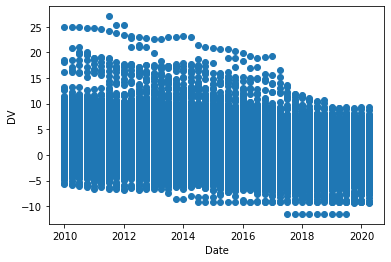

In [13]:
### Run Data Preparation Steps
data, helper = extract_data(df_name='dataf_interp2', DV='lCloseAvg', drop=['name','Office','Close','lClose','CloseAvg'])
locals().update(helper)

## Iterate Models Univariate

In [47]:
vars = dv
ts=8
n_out=4 # number of leeds to forecast
d_out=4 # number of leeds to forecast
# Create training datasets
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data(data, vars, val_mths=4, ts=ts)

Train:  (53622, 8, 1) 53622
Valid:  (3035, 8, 1) 3035
Test:  (3035, 8, 1) 3035


### Varying Batch 0.683 / 0.390

In [32]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

Epoch 000: Train Loss: 0.0069, Test Loss: 0.0623
Time taken: 29.25s
Epoch 001: Train Loss: 0.0068, Test Loss: 0.0560
Time taken: 21.55s
Epoch 002: Train Loss: 0.0068, Test Loss: 0.0560
Time taken: 21.86s
Epoch 003: Train Loss: 0.0066, Test Loss: 0.0552
Time taken: 21.27s
Epoch 004: Train Loss: 0.0065, Test Loss: 0.0550
Time taken: 21.55s
Epoch 005: Train Loss: 0.0063, Test Loss: 0.0554
Time taken: 21.96s
Epoch 006: Train Loss: 0.0065, Test Loss: 0.0546
Time taken: 21.50s
Epoch 007: Train Loss: 0.0066, Test Loss: 0.0550
Time taken: 21.56s
Epoch 008: Train Loss: 0.0064, Test Loss: 0.0538
Time taken: 21.36s
Epoch 009: Train Loss: 0.0064, Test Loss: 0.0543
Time taken: 21.38s
Epoch 010: Train Loss: 0.0062, Test Loss: 0.0542
Time taken: 21.22s
Epoch 011: Train Loss: 0.0063, Test Loss: 0.0542
Time taken: 21.40s
Epoch 012: Train Loss: 0.0062, Test Loss: 0.0538
Time taken: 21.37s
Epoch 013: Train Loss: 0.0062, Test Loss: 0.0533
Time taken: 21.40s
Epoch 014: Train Loss: 0.0062, Test Loss: 0.0534

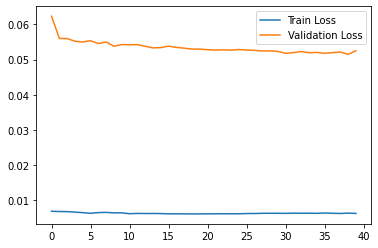

Performance on Test data:
Test RMSE: 0.683
Test MAE: 0.390
Test RMSE period 0: 0.365
Test RMSE period 1: 0.541
Test RMSE period 2: 0.710
Test RMSE period 3: 0.968
Test MAE period 0: 0.212
Test MAE period 1: 0.317
Test MAE period 2: 0.419
Test MAE period 3: 0.611
Test FID: 0.578


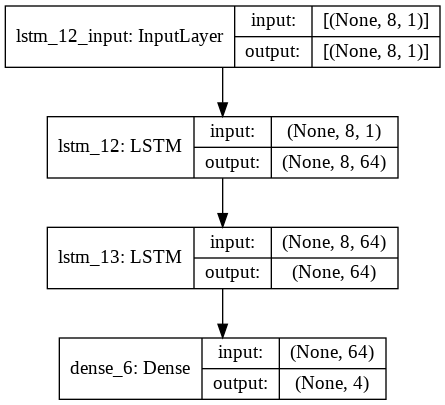

In [47]:
# Univariate model with varying batch
model, history, rmse, mae = run_model_var(n_epochs=3000,
                                              n_layers=1, lstm_units=64, 
                                              lr=0.001, 
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

### Fixed Batch 0.695 / 0.391

Epoch 1/3000
1676/1676 - 11s - loss: 0.1100 - val_loss: 0.0755
Epoch 2/3000
1676/1676 - 7s - loss: 0.0618 - val_loss: 0.0633
Epoch 3/3000
1676/1676 - 7s - loss: 0.0557 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0624
Epoch 5/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0625
Epoch 6/3000
1676/1676 - 7s - loss: 0.0543 - val_loss: 0.0627
Epoch 7/3000
1676/1676 - 7s - loss: 0.0542 - val_loss: 0.0628
Epoch 8/3000
1676/1676 - 7s - loss: 0.0539 - val_loss: 0.0627
Epoch 9/3000
1676/1676 - 7s - loss: 0.0535 - val_loss: 0.0625
Epoch 10/3000
1676/1676 - 7s - loss: 0.0538 - val_loss: 0.0625
Epoch 11/3000
1676/1676 - 7s - loss: 0.0533 - val_loss: 0.0622
Epoch 12/3000
1676/1676 - 7s - loss: 0.0532 - val_loss: 0.0619
Epoch 13/3000
1676/1676 - 7s - loss: 0.0532 - val_loss: 0.0626
Epoch 14/3000
1676/1676 - 7s - loss: 0.0529 - val_loss: 0.0617
Epoch 15/3000
1676/1676 - 7s - loss: 0.0528 - val_loss: 0.0618
Epoch 16/3000
1676/1676 - 7s - loss: 0.0526 - val_loss: 0.0616


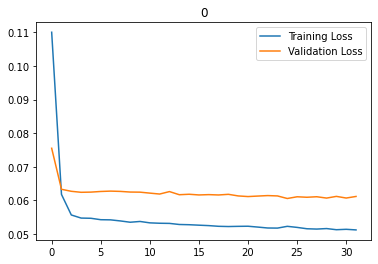

Performance on Test data:
Test RMSE: 0.695
Test MAE: 0.391
Test RMSE period 0: 0.373
Test RMSE period 1: 0.554
Test RMSE period 2: 0.724
Test RMSE period 3: 0.980
Test MAE period 0: 0.211
Test MAE period 1: 0.318
Test MAE period 2: 0.422
Test MAE period 3: 0.614
Test FID: 0.573


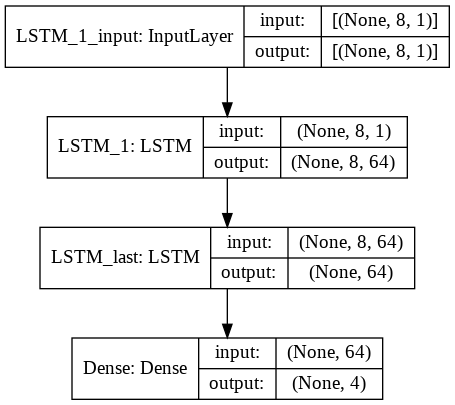

In [35]:
# Univariate model with fixed batch
# Set parameters
autoenc=0

model, history, rmse, mae = run_model_fix(n_epochs=3000, autoenc=autoenc, drop=0, 
                                              n_layers=[1,1], lstm_units=64, 
                                              n_batch_size=32, lr=0.001, 
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

### Fixed Batch MAE 0.693 / 0.397

Epoch 1/3000
1676/1676 - 10s - loss: 0.1731 - val_loss: 0.1711
Epoch 2/3000
1676/1676 - 7s - loss: 0.1327 - val_loss: 0.1668
Epoch 3/3000
1676/1676 - 7s - loss: 0.1310 - val_loss: 0.1694
Epoch 4/3000
1676/1676 - 7s - loss: 0.1303 - val_loss: 0.1689
Epoch 5/3000
1676/1676 - 7s - loss: 0.1298 - val_loss: 0.1659
Epoch 6/3000
1676/1676 - 7s - loss: 0.1295 - val_loss: 0.1656
Epoch 7/3000
1676/1676 - 7s - loss: 0.1292 - val_loss: 0.1642
Epoch 8/3000
1676/1676 - 7s - loss: 0.1288 - val_loss: 0.1639
Epoch 9/3000
1676/1676 - 7s - loss: 0.1289 - val_loss: 0.1618
Epoch 10/3000
1676/1676 - 7s - loss: 0.1285 - val_loss: 0.1609
Epoch 11/3000
1676/1676 - 7s - loss: 0.1282 - val_loss: 0.1588
Epoch 12/3000
1676/1676 - 7s - loss: 0.1277 - val_loss: 0.1588
Epoch 13/3000
1676/1676 - 7s - loss: 0.1276 - val_loss: 0.1591
Epoch 14/3000
1676/1676 - 7s - loss: 0.1274 - val_loss: 0.1569
Epoch 15/3000
1676/1676 - 7s - loss: 0.1272 - val_loss: 0.1559
Epoch 16/3000
1676/1676 - 7s - loss: 0.1270 - val_loss: 0.1560


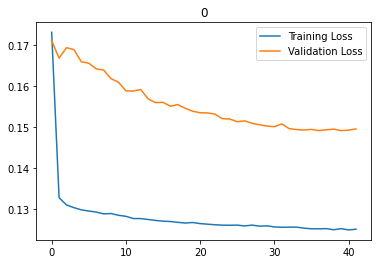

Performance on Test data:
Test RMSE: 0.693
Test MAE: 0.397
Test RMSE period 0: 0.367
Test RMSE period 1: 0.551
Test RMSE period 2: 0.710
Test RMSE period 3: 0.988
Test MAE period 0: 0.215
Test MAE period 1: 0.320
Test MAE period 2: 0.412
Test MAE period 3: 0.642
Test FID: 0.582


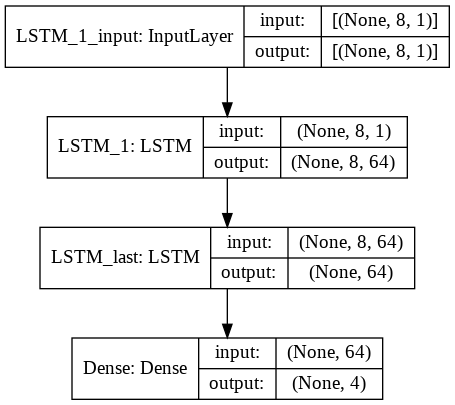

In [27]:
# Univariate model with fixed batch
model, history, rmse, mae = run_model_fix(n_epochs=3000,
                                              n_layers=[1,1], lstm_units=64, 
                                              lr=0.001, n_batch_size=32,
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

### Fixed Batch MinMax 0.699 / 0.389

Epoch 1/3000
1676/1676 - 11s - loss: 0.0014 - val_loss: 6.4509e-04
Epoch 2/3000
1676/1676 - 7s - loss: 4.8273e-04 - val_loss: 4.5263e-04
Epoch 3/3000
1676/1676 - 7s - loss: 3.4331e-04 - val_loss: 2.8665e-04
Epoch 4/3000
1676/1676 - 7s - loss: 2.4753e-04 - val_loss: 2.3161e-04
Epoch 5/3000
1676/1676 - 7s - loss: 2.2459e-04 - val_loss: 2.2324e-04
Epoch 6/3000
1676/1676 - 7s - loss: 2.1894e-04 - val_loss: 2.2245e-04
Epoch 7/3000
1676/1676 - 7s - loss: 2.1553e-04 - val_loss: 2.2132e-04
Epoch 8/3000
1676/1676 - 7s - loss: 2.1280e-04 - val_loss: 2.2096e-04
Epoch 9/3000
1676/1676 - 7s - loss: 2.1067e-04 - val_loss: 2.2141e-04
Epoch 10/3000
1676/1676 - 7s - loss: 2.0884e-04 - val_loss: 2.2285e-04
Epoch 11/3000
1676/1676 - 7s - loss: 2.0731e-04 - val_loss: 2.2382e-04
*CB_ES* Loss didn't change much from last 5 epochs
*CB_ES* Percent change in loss value: 0.006124443316366522


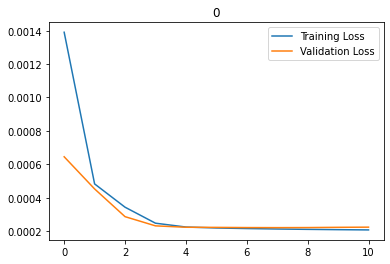

Performance on Test data:
Test RMSE: 0.699
Test MAE: 0.389
Test RMSE period 0: 0.361
Test RMSE period 1: 0.554
Test RMSE period 2: 0.730
Test RMSE period 3: 0.992
Test MAE period 0: 0.206
Test MAE period 1: 0.316
Test MAE period 2: 0.430
Test MAE period 3: 0.604
Test FID: 0.527


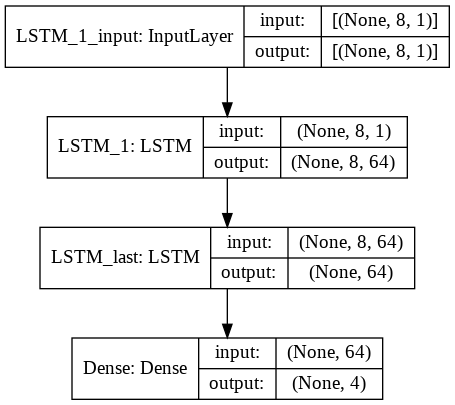

In [38]:
# Univariate model with fixed batch
model, history, rmse, mae = run_model_fix(n_epochs=3000,
                                              n_layers=[1,1], lstm_units=64, 
                                              lr=0.001, n_batch_size=32,
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

### Fixed Batch EncDec 0.707 / 0.395

Epoch 1/3000
1676/1676 - 10s - loss: 0.0941 - val_loss: 0.0661
Epoch 2/3000
1676/1676 - 7s - loss: 0.0572 - val_loss: 0.0627
Epoch 3/3000
1676/1676 - 7s - loss: 0.0558 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0550 - val_loss: 0.0627
Epoch 5/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0625
Epoch 6/3000
1676/1676 - 7s - loss: 0.0545 - val_loss: 0.0625
Epoch 7/3000
1676/1676 - 7s - loss: 0.0543 - val_loss: 0.0623
Epoch 8/3000
1676/1676 - 7s - loss: 0.0541 - val_loss: 0.0624
Epoch 9/3000
1676/1676 - 7s - loss: 0.0541 - val_loss: 0.0624
Epoch 10/3000
1676/1676 - 7s - loss: 0.0540 - val_loss: 0.0626
Epoch 11/3000
1676/1676 - 7s - loss: 0.0538 - val_loss: 0.0625
Epoch 12/3000
1676/1676 - 7s - loss: 0.0535 - val_loss: 0.0623
Epoch 13/3000
1676/1676 - 7s - loss: 0.0534 - val_loss: 0.0625
*CB_ES* Loss didn't change much from last 5 epochs
*CB_ES* Percent change in loss value: 0.005910396575927596


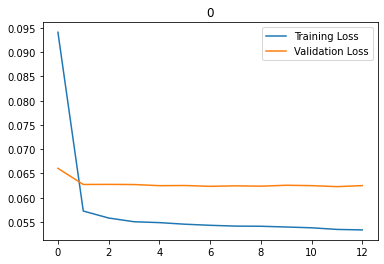

Performance on Test data:
Test RMSE: 0.707
Test MAE: 0.395
Test RMSE period 0: 0.368
Test RMSE period 1: 0.562
Test RMSE period 2: 0.738
Test RMSE period 3: 1.003
Test MAE period 0: 0.207
Test MAE period 1: 0.320
Test MAE period 2: 0.425
Test MAE period 3: 0.628
Test FID: 0.616


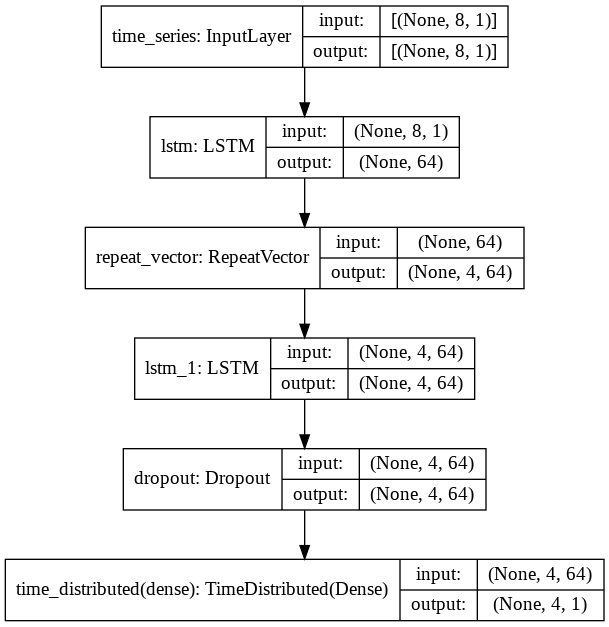

In [41]:
# Univariate model with fixed batch
model, history, rmse, mae = run_model_fix(n_epochs=3000, autoenc=1,
                                              n_layers=[1,1], lstm_units=64, 
                                              lr=0.001, n_batch_size=32,
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

### Fixed Batch 4 ts 0.708 / 0.401

In [43]:
vars = dv
ts=4
# Create training datasets
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data(data, vars, val_mths=4, ts=ts)

Train:  (65762, 4, 1) 65762
Valid:  (3035, 4, 1) 3035
Test:  (3035, 4, 1) 3035


Epoch 1/3000
2056/2056 - 12s - loss: 0.0964 - val_loss: 0.0744
Epoch 2/3000
2056/2056 - 8s - loss: 0.0641 - val_loss: 0.0639
Epoch 3/3000
2056/2056 - 8s - loss: 0.0604 - val_loss: 0.0635
Epoch 4/3000
2056/2056 - 8s - loss: 0.0604 - val_loss: 0.0631
Epoch 5/3000
2056/2056 - 8s - loss: 0.0601 - val_loss: 0.0630
Epoch 6/3000
2056/2056 - 8s - loss: 0.0585 - val_loss: 0.0634
Epoch 7/3000
2056/2056 - 8s - loss: 0.0579 - val_loss: 0.0635
Epoch 8/3000
2056/2056 - 8s - loss: 0.0578 - val_loss: 0.0633
Epoch 9/3000
2056/2056 - 8s - loss: 0.0579 - val_loss: 0.0634
Epoch 10/3000
2056/2056 - 8s - loss: 0.0567 - val_loss: 0.0632
Epoch 11/3000
2056/2056 - 8s - loss: 0.0569 - val_loss: 0.0630
*CB_ES* Loss didn't change much from last 5 epochs
*CB_ES* Percent change in loss value: 0.009537488222122192


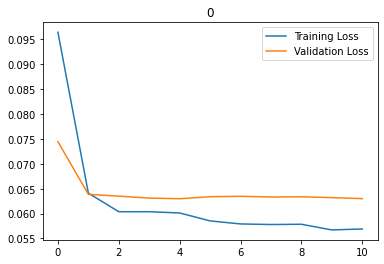

Performance on Test data:
Test RMSE: 0.708
Test MAE: 0.401
Test RMSE period 0: 0.374
Test RMSE period 1: 0.560
Test RMSE period 2: 0.738
Test RMSE period 3: 1.005
Test MAE period 0: 0.220
Test MAE period 1: 0.324
Test MAE period 2: 0.426
Test MAE period 3: 0.632
Test FID: 0.675


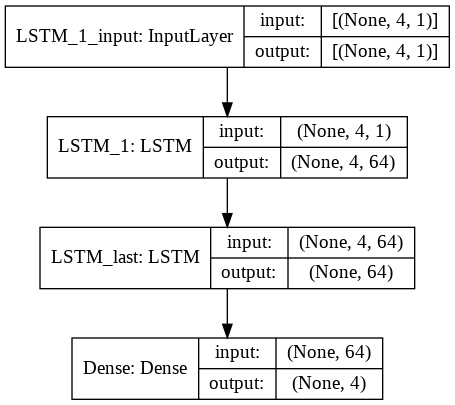

In [46]:
# Univariate model with fixed batch
model, history, rmse, mae = run_model_fix(n_epochs=3000,
                                              n_layers=[1,1], lstm_units=64, 
                                              lr=0.001, n_batch_size=32,
                                              reg=[0,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Forecast
all_lag, y_act, yhat, impt_var, rmse = prediction(model, scalers, importance=0, autoenc=0)
# Plots
# Max/Min differences
ydiff = pd.DataFrame(index = all_lag.index, columns=['dif'])
ydiff['dif'] = (y_act - yhat)**2
ydiff_co = np.sqrt(ydiff.reset_index().groupby('cik').mean('dif'))
ydiff_co = ydiff_co.sort_values(by='dif',ascending=False)
ydiff_co = ydiff_co.reset_index()

f_yr=5 # number of years for comparison
step=4 # step in quarters
sample_plot(co=companies[0], f_yr=f_yr, step=step)
sample_plot(co=companies[100], f_yr=f_yr, step=step)
sample_plot(co=ydiff_co.iloc[0,0], f_yr=f_yr, step=step) # worst fit
sample_plot(co=ydiff_co.iloc[-1,0], f_yr=f_yr, step=step) # best fit

### Iterate

Epoch 1/3000
1676/1676 - 10s - loss: 0.1075 - val_loss: 0.0740
Epoch 2/3000
1676/1676 - 7s - loss: 0.0612 - val_loss: 0.0630
Epoch 3/3000
1676/1676 - 7s - loss: 0.0552 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0552 - val_loss: 0.0624
Epoch 5/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0625
Epoch 6/3000
1676/1676 - 7s - loss: 0.0543 - val_loss: 0.0624
Epoch 7/3000
1676/1676 - 7s - loss: 0.0541 - val_loss: 0.0624
Epoch 8/3000
1676/1676 - 7s - loss: 0.0536 - val_loss: 0.0621
Epoch 9/3000
1676/1676 - 7s - loss: 0.0540 - val_loss: 0.0624
Epoch 10/3000
1676/1676 - 7s - loss: 0.0534 - val_loss: 0.0620
Epoch 11/3000
1676/1676 - 7s - loss: 0.0531 - val_loss: 0.0617
Epoch 12/3000
1676/1676 - 7s - loss: 0.0532 - val_loss: 0.0618
Epoch 13/3000
1676/1676 - 7s - loss: 0.0527 - val_loss: 0.0616
Epoch 14/3000
1676/1676 - 7s - loss: 0.0528 - val_loss: 0.0617
Epoch 15/3000
1676/1676 - 7s - loss: 0.0525 - val_loss: 0.0618
Epoch 16/3000
1676/1676 - 7s - loss: 0.0524 - val_loss: 0.0614


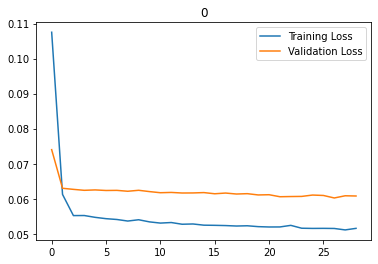

Performance on Test data:
Test RMSE: 0.700
Test MAE: 0.391
Test RMSE period 0: 0.377
Test RMSE period 1: 0.560
Test RMSE period 2: 0.730
Test RMSE period 3: 0.984
Test MAE period 0: 0.211
Test MAE period 1: 0.318
Test MAE period 2: 0.421
Test MAE period 3: 0.614
Test FID: 0.570
iter          0.000000
Epoch        29.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051546
ValidLoss     0.060780
RMSE          0.699506
MAE           0.390967
Name: 0, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1089 - val_loss: 0.0747
Epoch 2/3000
1676/1676 - 7s - loss: 0.0619 - val_loss: 0.0635
Epoch 3/3000
1676/1676 - 7s - loss: 0.0558 - val_loss: 0.0628
Epoch 4/3000
1676/1676 - 7s - loss: 0.0550 - val_loss: 0.0629
Epoch 5/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0631
Epoch 6/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0628
Ep

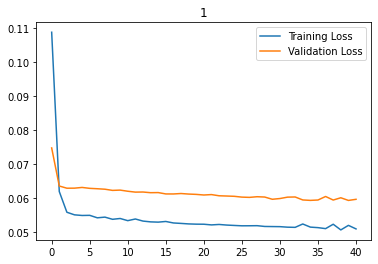

Performance on Test data:
Test RMSE: 0.693
Test MAE: 0.388
Test RMSE period 0: 0.372
Test RMSE period 1: 0.553
Test RMSE period 2: 0.722
Test RMSE period 3: 0.978
Test MAE period 0: 0.207
Test MAE period 1: 0.314
Test MAE period 2: 0.416
Test MAE period 3: 0.614
Test FID: 0.565
iter          1.000000
Epoch        41.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000100
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.050835
ValidLoss     0.059574
RMSE          0.693251
MAE           0.387684
Name: 1, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1098 - val_loss: 0.0747
Epoch 2/3000
1676/1676 - 7s - loss: 0.0614 - val_loss: 0.0629
Epoch 3/3000
1676/1676 - 7s - loss: 0.0555 - val_loss: 0.0624
Epoch 4/3000
1676/1676 - 7s - loss: 0.0554 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0624
Epoch 6/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0622
Ep

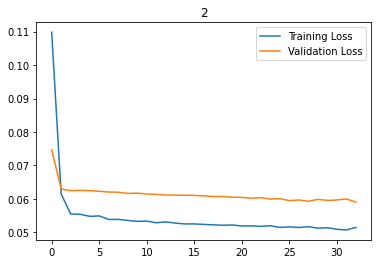

Performance on Test data:
Test RMSE: 0.689
Test MAE: 0.387
Test RMSE period 0: 0.371
Test RMSE period 1: 0.549
Test RMSE period 2: 0.715
Test RMSE period 3: 0.975
Test MAE period 0: 0.210
Test MAE period 1: 0.314
Test MAE period 2: 0.414
Test MAE period 3: 0.612
Test FID: 0.566
iter          2.000000
Epoch        33.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000100
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051428
ValidLoss     0.059015
RMSE          0.689273
MAE           0.387363
Name: 2, dtype: float64
Epoch 1/3000
1676/1676 - 10s - loss: 0.1113 - val_loss: 0.0773
Epoch 2/3000
1676/1676 - 7s - loss: 0.0633 - val_loss: 0.0653
Epoch 3/3000
1676/1676 - 7s - loss: 0.0571 - val_loss: 0.0645
Epoch 4/3000
1676/1676 - 7s - loss: 0.0565 - val_loss: 0.0640
Epoch 5/3000
1676/1676 - 7s - loss: 0.0562 - val_loss: 0.0636
Epoch 6/3000
1676/1676 - 7s - loss: 0.0556 - val_loss: 0.0634
Ep

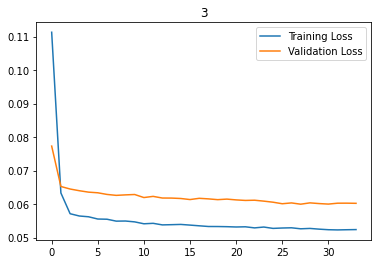

Performance on Test data:
Test RMSE: 0.685
Test MAE: 0.388
Test RMSE period 0: 0.362
Test RMSE period 1: 0.540
Test RMSE period 2: 0.712
Test RMSE period 3: 0.973
Test MAE period 0: 0.208
Test MAE period 1: 0.314
Test MAE period 2: 0.417
Test MAE period 3: 0.611
Test FID: 0.590
iter          3.000000
Epoch        34.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000100
uLSTM        64.000000
TrainLoss     0.052408
ValidLoss     0.060245
RMSE          0.685090
MAE           0.387537
Name: 3, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1078 - val_loss: 0.0756
Epoch 2/3000
1676/1676 - 7s - loss: 0.0627 - val_loss: 0.0631
Epoch 3/3000
1676/1676 - 7s - loss: 0.0553 - val_loss: 0.0625
Epoch 4/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0546 - val_loss: 0.0625
Epoch 6/3000
1676/1676 - 7s - loss: 0.0543 - val_loss: 0.0624
Ep

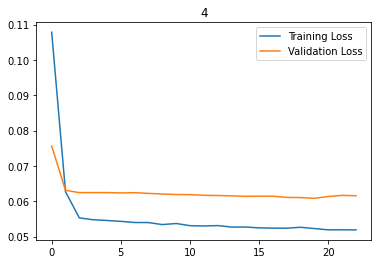

Performance on Test data:
Test RMSE: 0.697
Test MAE: 0.391
Test RMSE period 0: 0.373
Test RMSE period 1: 0.552
Test RMSE period 2: 0.729
Test RMSE period 3: 0.984
Test MAE period 0: 0.211
Test MAE period 1: 0.317
Test MAE period 2: 0.424
Test MAE period 3: 0.613
Test FID: 0.588
iter          4.000000
Epoch        23.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000001
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051907
ValidLoss     0.061585
RMSE          0.697177
MAE           0.391232
Name: 4, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1072 - val_loss: 0.0745
Epoch 2/3000
1676/1676 - 7s - loss: 0.0613 - val_loss: 0.0629
Epoch 3/3000
1676/1676 - 7s - loss: 0.0555 - val_loss: 0.0626
Epoch 4/3000
1676/1676 - 7s - loss: 0.0550 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0627
Epoch 6/3000
1676/1676 - 7s - loss: 0.0546 - val_loss: 0.0626
Ep

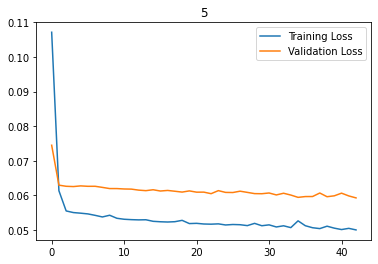

Performance on Test data:
Test RMSE: 0.686
Test MAE: 0.387
Test RMSE period 0: 0.371
Test RMSE period 1: 0.546
Test RMSE period 2: 0.715
Test RMSE period 3: 0.968
Test MAE period 0: 0.210
Test MAE period 1: 0.314
Test MAE period 2: 0.414
Test MAE period 3: 0.609
Test FID: 0.556
iter          5.000000
Epoch        43.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000001
RR            0.000000
uLSTM        64.000000
TrainLoss     0.049987
ValidLoss     0.059248
RMSE          0.686316
MAE           0.386674
Name: 5, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1068 - val_loss: 0.0743
Epoch 2/3000
1676/1676 - 7s - loss: 0.0607 - val_loss: 0.0636
Epoch 3/3000
1676/1676 - 7s - loss: 0.0551 - val_loss: 0.0626
Epoch 4/3000
1676/1676 - 7s - loss: 0.0551 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0628
Epoch 6/3000
1676/1676 - 7s - loss: 0.0546 - val_loss: 0.0627
Ep

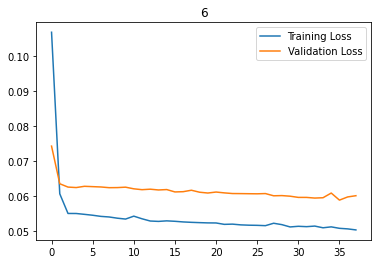

Performance on Test data:
Test RMSE: 0.688
Test MAE: 0.389
Test RMSE period 0: 0.371
Test RMSE period 1: 0.547
Test RMSE period 2: 0.717
Test RMSE period 3: 0.971
Test MAE period 0: 0.211
Test MAE period 1: 0.315
Test MAE period 2: 0.417
Test MAE period 3: 0.611
Test FID: 0.577
iter          6.000000
Epoch        38.000000
TS            8.000000
Dropout       0.000000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000001
uLSTM        64.000000
TrainLoss     0.050362
ValidLoss     0.060136
RMSE          0.688156
MAE           0.388646
Name: 6, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1345 - val_loss: 0.0805
Epoch 2/3000
1676/1676 - 9s - loss: 0.0699 - val_loss: 0.0632
Epoch 3/3000
1676/1676 - 10s - loss: 0.0598 - val_loss: 0.0629
Epoch 4/3000
1676/1676 - 10s - loss: 0.0576 - val_loss: 0.0633
Epoch 5/3000
1676/1676 - 9s - loss: 0.0580 - val_loss: 0.0629
Epoch 6/3000
1676/1676 - 10s - loss: 0.0570 - val_loss: 0.0631

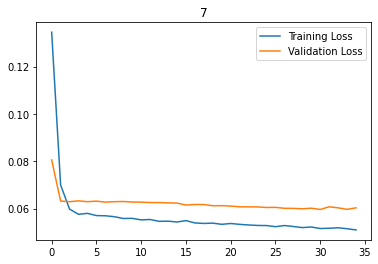

Performance on Test data:
Test RMSE: 0.718
Test MAE: 0.396
Test RMSE period 0: 0.427
Test RMSE period 1: 0.593
Test RMSE period 2: 0.744
Test RMSE period 3: 0.987
Test MAE period 0: 0.218
Test MAE period 1: 0.324
Test MAE period 2: 0.423
Test MAE period 3: 0.619
Test FID: 0.567
iter          7.000000
Epoch        35.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.050964
ValidLoss     0.060299
RMSE          0.717974
MAE           0.395870
Name: 7, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1392 - val_loss: 0.0887
Epoch 2/3000
1676/1676 - 10s - loss: 0.0755 - val_loss: 0.0685
Epoch 3/3000
1676/1676 - 10s - loss: 0.0635 - val_loss: 0.0669
Epoch 4/3000
1676/1676 - 10s - loss: 0.0599 - val_loss: 0.0660
Epoch 5/3000
1676/1676 - 10s - loss: 0.0595 - val_loss: 0.0656
Epoch 6/3000
1676/1676 - 10s - loss: 0.0586 - val_loss: 0.06

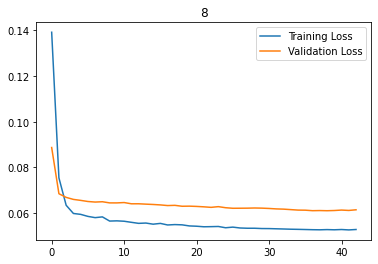

Performance on Test data:
Test RMSE: 0.698
Test MAE: 0.397
Test RMSE period 0: 0.371
Test RMSE period 1: 0.549
Test RMSE period 2: 0.720
Test RMSE period 3: 0.995
Test MAE period 0: 0.216
Test MAE period 1: 0.320
Test MAE period 2: 0.421
Test MAE period 3: 0.631
Test FID: 0.633
iter          8.000000
Epoch        43.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000100
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.052876
ValidLoss     0.061496
RMSE          0.697699
MAE           0.397034
Name: 8, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1377 - val_loss: 0.0845
Epoch 2/3000
1676/1676 - 9s - loss: 0.0711 - val_loss: 0.0640
Epoch 3/3000
1676/1676 - 9s - loss: 0.0579 - val_loss: 0.0633
Epoch 4/3000
1676/1676 - 9s - loss: 0.0588 - val_loss: 0.0631
Epoch 5/3000
1676/1676 - 9s - loss: 0.0570 - val_loss: 0.0632
Epoch 6/3000
1676/1676 - 10s - loss: 0.0573 - val_loss: 0.0631
E

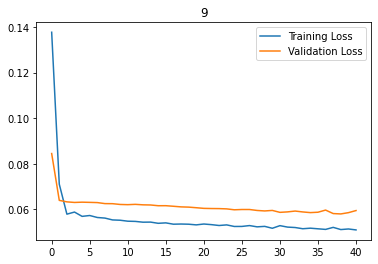

Performance on Test data:
Test RMSE: 0.715
Test MAE: 0.394
Test RMSE period 0: 0.416
Test RMSE period 1: 0.589
Test RMSE period 2: 0.744
Test RMSE period 3: 0.987
Test MAE period 0: 0.217
Test MAE period 1: 0.322
Test MAE period 2: 0.422
Test MAE period 3: 0.616
Test FID: 0.568
iter          9.000000
Epoch        41.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000100
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051014
ValidLoss     0.059505
RMSE          0.715271
MAE           0.394188
Name: 9, dtype: float64
Epoch 1/3000
1676/1676 - 16s - loss: 0.1429 - val_loss: 0.0874
Epoch 2/3000
1676/1676 - 10s - loss: 0.0736 - val_loss: 0.0678
Epoch 3/3000
1676/1676 - 10s - loss: 0.0618 - val_loss: 0.0665
Epoch 4/3000
1676/1676 - 10s - loss: 0.0607 - val_loss: 0.0660
Epoch 5/3000
1676/1676 - 10s - loss: 0.0610 - val_loss: 0.0656
Epoch 6/3000
1676/1676 - 10s - loss: 0.0604 - val_loss: 0.06

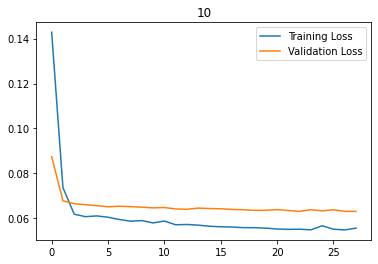

Performance on Test data:
Test RMSE: 0.696
Test MAE: 0.397
Test RMSE period 0: 0.368
Test RMSE period 1: 0.547
Test RMSE period 2: 0.721
Test RMSE period 3: 0.991
Test MAE period 0: 0.217
Test MAE period 1: 0.320
Test MAE period 2: 0.422
Test MAE period 3: 0.630
Test FID: 0.621
iter         10.000000
Epoch        28.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000100
uLSTM        64.000000
TrainLoss     0.055576
ValidLoss     0.063037
RMSE          0.695718
MAE           0.397366
Name: 10, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1342 - val_loss: 0.0830
Epoch 2/3000
1676/1676 - 10s - loss: 0.0699 - val_loss: 0.0633
Epoch 3/3000
1676/1676 - 10s - loss: 0.0597 - val_loss: 0.0630
Epoch 4/3000
1676/1676 - 10s - loss: 0.0580 - val_loss: 0.0632
Epoch 5/3000
1676/1676 - 10s - loss: 0.0569 - val_loss: 0.0630
Epoch 6/3000
1676/1676 - 10s - loss: 0.0581 - val_loss: 0.0

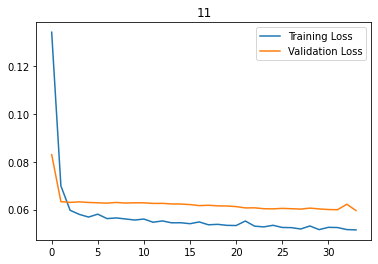

Performance on Test data:
Test RMSE: 0.732
Test MAE: 0.397
Test RMSE period 0: 0.438
Test RMSE period 1: 0.610
Test RMSE period 2: 0.764
Test RMSE period 3: 0.999
Test MAE period 0: 0.219
Test MAE period 1: 0.324
Test MAE period 2: 0.424
Test MAE period 3: 0.621
Test FID: 0.575
iter         11.000000
Epoch        34.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000001
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051478
ValidLoss     0.059585
RMSE          0.732322
MAE           0.396996
Name: 11, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1375 - val_loss: 0.0837
Epoch 2/3000
1676/1676 - 10s - loss: 0.0707 - val_loss: 0.0633
Epoch 3/3000
1676/1676 - 10s - loss: 0.0604 - val_loss: 0.0631
Epoch 4/3000
1676/1676 - 10s - loss: 0.0572 - val_loss: 0.0633
Epoch 5/3000
1676/1676 - 10s - loss: 0.0580 - val_loss: 0.0631
Epoch 6/3000
1676/1676 - 9s - loss: 0.0572 - val_loss: 0.06

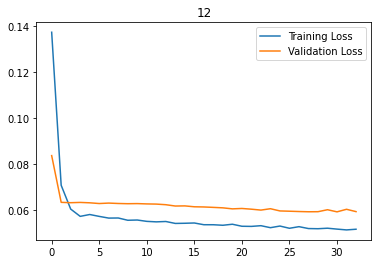

Performance on Test data:
Test RMSE: 0.706
Test MAE: 0.394
Test RMSE period 0: 0.400
Test RMSE period 1: 0.572
Test RMSE period 2: 0.736
Test RMSE period 3: 0.982
Test MAE period 0: 0.218
Test MAE period 1: 0.321
Test MAE period 2: 0.421
Test MAE period 3: 0.618
Test FID: 0.594
iter         12.000000
Epoch        33.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000001
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051570
ValidLoss     0.059246
RMSE          0.706054
MAE           0.394271
Name: 12, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1370 - val_loss: 0.0852
Epoch 2/3000
1676/1676 - 10s - loss: 0.0721 - val_loss: 0.0636
Epoch 3/3000
1676/1676 - 10s - loss: 0.0598 - val_loss: 0.0635
Epoch 4/3000
1676/1676 - 10s - loss: 0.0581 - val_loss: 0.0636
Epoch 5/3000
1676/1676 - 10s - loss: 0.0576 - val_loss: 0.0634
Epoch 6/3000
1676/1676 - 10s - loss: 0.0575 - val_loss: 0.0

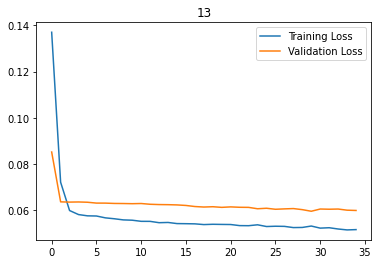

Performance on Test data:
Test RMSE: 0.712
Test MAE: 0.393
Test RMSE period 0: 0.414
Test RMSE period 1: 0.584
Test RMSE period 2: 0.739
Test RMSE period 3: 0.986
Test MAE period 0: 0.216
Test MAE period 1: 0.321
Test MAE period 2: 0.419
Test MAE period 3: 0.616
Test FID: 0.576
iter         13.000000
Epoch        35.000000
TS            8.000000
Dropout       0.000000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000001
uLSTM        64.000000
TrainLoss     0.051586
ValidLoss     0.059878
RMSE          0.712460
MAE           0.392860
Name: 13, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1097 - val_loss: 0.0759
Epoch 2/3000
1676/1676 - 7s - loss: 0.0624 - val_loss: 0.0634
Epoch 3/3000
1676/1676 - 7s - loss: 0.0552 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0550 - val_loss: 0.0626
Epoch 5/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0625
Epoch 6/3000
1676/1676 - 7s - loss: 0.0545 - val_loss: 0.0626
E

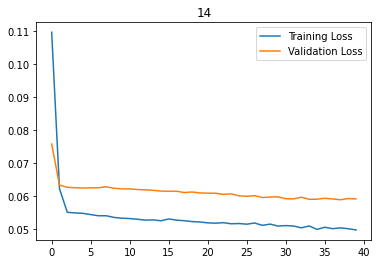

Performance on Test data:
Test RMSE: 0.695
Test MAE: 0.390
Test RMSE period 0: 0.380
Test RMSE period 1: 0.557
Test RMSE period 2: 0.725
Test RMSE period 3: 0.976
Test MAE period 0: 0.214
Test MAE period 1: 0.317
Test MAE period 2: 0.416
Test MAE period 3: 0.612
Test FID: 0.553
iter         14.000000
Epoch        40.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.049852
ValidLoss     0.059240
RMSE          0.695103
MAE           0.389567
Name: 14, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1082 - val_loss: 0.0752
Epoch 2/3000
1676/1676 - 7s - loss: 0.0623 - val_loss: 0.0635
Epoch 3/3000
1676/1676 - 7s - loss: 0.0555 - val_loss: 0.0630
Epoch 4/3000
1676/1676 - 7s - loss: 0.0554 - val_loss: 0.0628
Epoch 5/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0630
Epoch 6/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0627
E

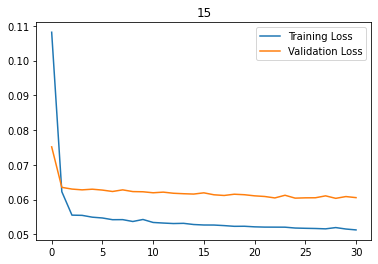

Performance on Test data:
Test RMSE: 0.692
Test MAE: 0.389
Test RMSE period 0: 0.367
Test RMSE period 1: 0.547
Test RMSE period 2: 0.720
Test RMSE period 3: 0.980
Test MAE period 0: 0.208
Test MAE period 1: 0.315
Test MAE period 2: 0.420
Test MAE period 3: 0.614
Test FID: 0.582
iter         15.000000
Epoch        31.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000100
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051242
ValidLoss     0.060540
RMSE          0.691570
MAE           0.389442
Name: 15, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1087 - val_loss: 0.0761
Epoch 2/3000
1676/1676 - 7s - loss: 0.0620 - val_loss: 0.0634
Epoch 3/3000
1676/1676 - 7s - loss: 0.0553 - val_loss: 0.0628
Epoch 4/3000
1676/1676 - 7s - loss: 0.0553 - val_loss: 0.0630
Epoch 5/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0630
Epoch 6/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0627
E

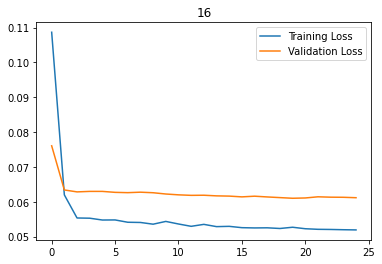

Performance on Test data:
Test RMSE: 0.697
Test MAE: 0.390
Test RMSE period 0: 0.372
Test RMSE period 1: 0.556
Test RMSE period 2: 0.726
Test RMSE period 3: 0.984
Test MAE period 0: 0.209
Test MAE period 1: 0.317
Test MAE period 2: 0.420
Test MAE period 3: 0.614
Test FID: 0.583
iter         16.000000
Epoch        25.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000100
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051903
ValidLoss     0.061150
RMSE          0.696932
MAE           0.390109
Name: 16, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1112 - val_loss: 0.0774
Epoch 2/3000
1676/1676 - 7s - loss: 0.0641 - val_loss: 0.0656
Epoch 3/3000
1676/1676 - 7s - loss: 0.0572 - val_loss: 0.0642
Epoch 4/3000
1676/1676 - 7s - loss: 0.0566 - val_loss: 0.0640
Epoch 5/3000
1676/1676 - 7s - loss: 0.0559 - val_loss: 0.0638
Epoch 6/3000
1676/1676 - 7s - loss: 0.0557 - val_loss: 0.0637
E

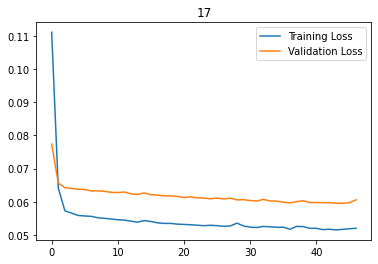

Performance on Test data:
Test RMSE: 0.687
Test MAE: 0.390
Test RMSE period 0: 0.368
Test RMSE period 1: 0.541
Test RMSE period 2: 0.713
Test RMSE period 3: 0.976
Test MAE period 0: 0.212
Test MAE period 1: 0.317
Test MAE period 2: 0.416
Test MAE period 3: 0.617
Test FID: 0.602
iter         17.000000
Epoch        47.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000100
uLSTM        64.000000
TrainLoss     0.051976
ValidLoss     0.060588
RMSE          0.687268
MAE           0.390321
Name: 17, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1096 - val_loss: 0.0751
Epoch 2/3000
1676/1676 - 7s - loss: 0.0617 - val_loss: 0.0628
Epoch 3/3000
1676/1676 - 7s - loss: 0.0557 - val_loss: 0.0623
Epoch 4/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0550 - val_loss: 0.0627
Epoch 6/3000
1676/1676 - 7s - loss: 0.0545 - val_loss: 0.0625
E

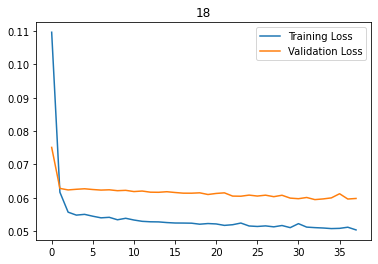

Performance on Test data:
Test RMSE: 0.682
Test MAE: 0.386
Test RMSE period 0: 0.360
Test RMSE period 1: 0.540
Test RMSE period 2: 0.709
Test RMSE period 3: 0.968
Test MAE period 0: 0.207
Test MAE period 1: 0.313
Test MAE period 2: 0.415
Test MAE period 3: 0.609
Test FID: 0.572
iter         18.000000
Epoch        38.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000001
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.050349
ValidLoss     0.059780
RMSE          0.682093
MAE           0.385976
Name: 18, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1087 - val_loss: 0.0735
Epoch 2/3000
1676/1676 - 7s - loss: 0.0624 - val_loss: 0.0629
Epoch 3/3000
1676/1676 - 7s - loss: 0.0562 - val_loss: 0.0625
Epoch 4/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0624
Epoch 6/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0622
E

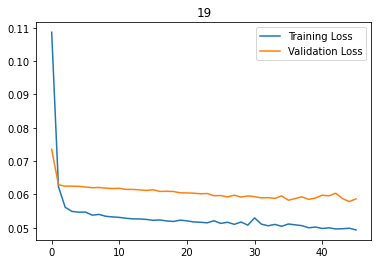

Performance on Test data:
Test RMSE: 0.692
Test MAE: 0.388
Test RMSE period 0: 0.383
Test RMSE period 1: 0.560
Test RMSE period 2: 0.721
Test RMSE period 3: 0.965
Test MAE period 0: 0.214
Test MAE period 1: 0.317
Test MAE period 2: 0.418
Test MAE period 3: 0.605
Test FID: 0.543
iter         19.000000
Epoch        46.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000001
RR            0.000000
uLSTM        64.000000
TrainLoss     0.049373
ValidLoss     0.058698
RMSE          0.691526
MAE           0.388368
Name: 19, dtype: float64
Epoch 1/3000
1676/1676 - 11s - loss: 0.1099 - val_loss: 0.0748
Epoch 2/3000
1676/1676 - 7s - loss: 0.0609 - val_loss: 0.0631
Epoch 3/3000
1676/1676 - 7s - loss: 0.0553 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0549 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0552 - val_loss: 0.0626
Epoch 6/3000
1676/1676 - 7s - loss: 0.0544 - val_loss: 0.0624
E

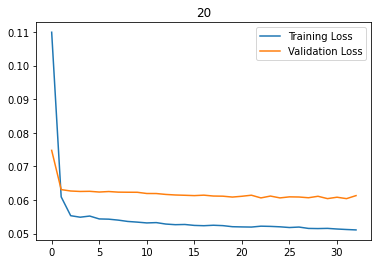

Performance on Test data:
Test RMSE: 0.689
Test MAE: 0.390
Test RMSE period 0: 0.369
Test RMSE period 1: 0.544
Test RMSE period 2: 0.717
Test RMSE period 3: 0.975
Test MAE period 0: 0.212
Test MAE period 1: 0.316
Test MAE period 2: 0.419
Test MAE period 3: 0.614
Test FID: 0.578
iter         20.000000
Epoch        33.000000
TS            8.000000
Dropout       0.300000
Layer1        1.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000001
uLSTM        64.000000
TrainLoss     0.051080
ValidLoss     0.061292
RMSE          0.688780
MAE           0.390425
Name: 20, dtype: float64
Epoch 1/3000
1676/1676 - 16s - loss: 0.1353 - val_loss: 0.0829
Epoch 2/3000
1676/1676 - 10s - loss: 0.0694 - val_loss: 0.0632
Epoch 3/3000
1676/1676 - 10s - loss: 0.0595 - val_loss: 0.0631
Epoch 4/3000
1676/1676 - 10s - loss: 0.0580 - val_loss: 0.0632
Epoch 5/3000
1676/1676 - 10s - loss: 0.0575 - val_loss: 0.0633
Epoch 6/3000
1676/1676 - 10s - loss: 0.0577 - val_loss: 0.0

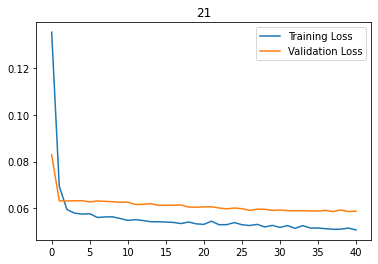

Performance on Test data:
Test RMSE: 0.733
Test MAE: 0.394
Test RMSE period 0: 0.447
Test RMSE period 1: 0.619
Test RMSE period 2: 0.764
Test RMSE period 3: 0.990
Test MAE period 0: 0.217
Test MAE period 1: 0.321
Test MAE period 2: 0.420
Test MAE period 3: 0.617
Test FID: 0.559
iter         21.000000
Epoch        41.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.050787
ValidLoss     0.058784
RMSE          0.732718
MAE           0.393661
Name: 21, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1392 - val_loss: 0.0880
Epoch 2/3000
1676/1676 - 10s - loss: 0.0748 - val_loss: 0.0684
Epoch 3/3000
1676/1676 - 10s - loss: 0.0642 - val_loss: 0.0667
Epoch 4/3000
1676/1676 - 10s - loss: 0.0601 - val_loss: 0.0657
Epoch 5/3000
1676/1676 - 10s - loss: 0.0600 - val_loss: 0.0653
Epoch 6/3000
1676/1676 - 10s - loss: 0.0591 - val_loss: 0.0

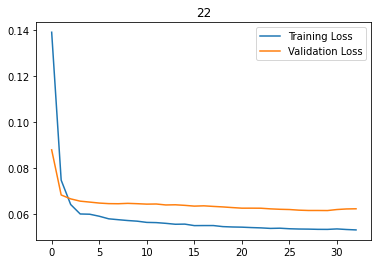

Performance on Test data:
Test RMSE: 0.698
Test MAE: 0.396
Test RMSE period 0: 0.364
Test RMSE period 1: 0.547
Test RMSE period 2: 0.722
Test RMSE period 3: 0.997
Test MAE period 0: 0.213
Test MAE period 1: 0.319
Test MAE period 2: 0.421
Test MAE period 3: 0.631
Test FID: 0.637
iter         22.000000
Epoch        33.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000100
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.053158
ValidLoss     0.062351
RMSE          0.697695
MAE           0.396186
Name: 22, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1326 - val_loss: 0.0801
Epoch 2/3000
1676/1676 - 10s - loss: 0.0695 - val_loss: 0.0638
Epoch 3/3000
1676/1676 - 10s - loss: 0.0598 - val_loss: 0.0634
Epoch 4/3000
1676/1676 - 10s - loss: 0.0580 - val_loss: 0.0635
Epoch 5/3000
1676/1676 - 10s - loss: 0.0578 - val_loss: 0.0634
Epoch 6/3000
1676/1676 - 9s - loss: 0.0576 - val_loss: 0.06

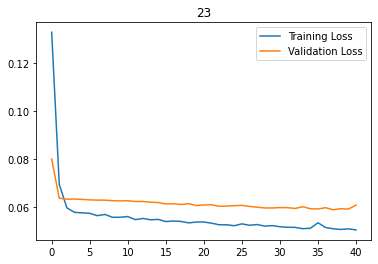

Performance on Test data:
Test RMSE: 0.741
Test MAE: 0.401
Test RMSE period 0: 0.445
Test RMSE period 1: 0.622
Test RMSE period 2: 0.772
Test RMSE period 3: 1.008
Test MAE period 0: 0.222
Test MAE period 1: 0.327
Test MAE period 2: 0.426
Test MAE period 3: 0.628
Test FID: 0.577
iter         23.000000
Epoch        41.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000100
RR            0.000000
uLSTM        64.000000
TrainLoss     0.050685
ValidLoss     0.060980
RMSE          0.741222
MAE           0.400660
Name: 23, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1388 - val_loss: 0.0866
Epoch 2/3000
1676/1676 - 10s - loss: 0.0740 - val_loss: 0.0676
Epoch 3/3000
1676/1676 - 10s - loss: 0.0632 - val_loss: 0.0666
Epoch 4/3000
1676/1676 - 10s - loss: 0.0618 - val_loss: 0.0662
Epoch 5/3000
1676/1676 - 10s - loss: 0.0606 - val_loss: 0.0658
Epoch 6/3000
1676/1676 - 10s - loss: 0.0613 - val_loss: 0.0

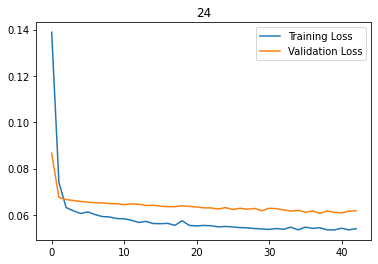

Performance on Test data:
Test RMSE: 0.695
Test MAE: 0.398
Test RMSE period 0: 0.369
Test RMSE period 1: 0.548
Test RMSE period 2: 0.719
Test RMSE period 3: 0.990
Test MAE period 0: 0.218
Test MAE period 1: 0.322
Test MAE period 2: 0.420
Test MAE period 3: 0.631
Test FID: 0.625
iter         24.000000
Epoch        43.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000100
uLSTM        64.000000
TrainLoss     0.054080
ValidLoss     0.061774
RMSE          0.695386
MAE           0.397771
Name: 24, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1356 - val_loss: 0.0816
Epoch 2/3000
1676/1676 - 10s - loss: 0.0705 - val_loss: 0.0635
Epoch 3/3000
1676/1676 - 10s - loss: 0.0599 - val_loss: 0.0632
Epoch 4/3000
1676/1676 - 10s - loss: 0.0577 - val_loss: 0.0633
Epoch 5/3000
1676/1676 - 10s - loss: 0.0588 - val_loss: 0.0631
Epoch 6/3000
1676/1676 - 10s - loss: 0.0566 - val_loss: 0.0

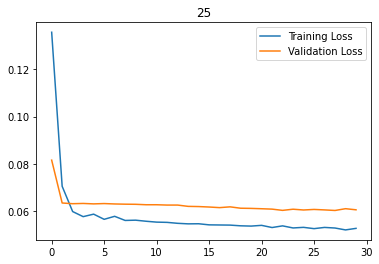

Performance on Test data:
Test RMSE: 0.696
Test MAE: 0.393
Test RMSE period 0: 0.378
Test RMSE period 1: 0.558
Test RMSE period 2: 0.721
Test RMSE period 3: 0.981
Test MAE period 0: 0.213
Test MAE period 1: 0.319
Test MAE period 2: 0.419
Test MAE period 3: 0.620
Test FID: 0.591
iter         25.000000
Epoch        30.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000001
AR            0.000000
RR            0.000000
uLSTM        64.000000
TrainLoss     0.052768
ValidLoss     0.060608
RMSE          0.696035
MAE           0.392744
Name: 25, dtype: float64
Epoch 1/3000
1676/1676 - 15s - loss: 0.1330 - val_loss: 0.0812
Epoch 2/3000
1676/1676 - 9s - loss: 0.0684 - val_loss: 0.0632
Epoch 3/3000
1676/1676 - 10s - loss: 0.0592 - val_loss: 0.0631
Epoch 4/3000
1676/1676 - 9s - loss: 0.0575 - val_loss: 0.0629
Epoch 5/3000
1676/1676 - 10s - loss: 0.0586 - val_loss: 0.0624
Epoch 6/3000
1676/1676 - 10s - loss: 0.0561 - val_loss: 0.062

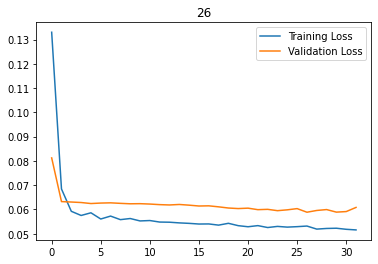

Performance on Test data:
Test RMSE: 0.688
Test MAE: 0.395
Test RMSE period 0: 0.367
Test RMSE period 1: 0.546
Test RMSE period 2: 0.714
Test RMSE period 3: 0.976
Test MAE period 0: 0.216
Test MAE period 1: 0.322
Test MAE period 2: 0.420
Test MAE period 3: 0.623
Test FID: 0.588
iter         26.000000
Epoch        32.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000001
RR            0.000000
uLSTM        64.000000
TrainLoss     0.051567
ValidLoss     0.060833
RMSE          0.688347
MAE           0.394966
Name: 26, dtype: float64
Epoch 1/3000
1676/1676 - 16s - loss: 0.1327 - val_loss: 0.0812
Epoch 2/3000
1676/1676 - 10s - loss: 0.0704 - val_loss: 0.0637
Epoch 3/3000
1676/1676 - 10s - loss: 0.0600 - val_loss: 0.0634
Epoch 4/3000
1676/1676 - 10s - loss: 0.0568 - val_loss: 0.0632
Epoch 5/3000
1676/1676 - 10s - loss: 0.0579 - val_loss: 0.0634
Epoch 6/3000
1676/1676 - 10s - loss: 0.0569 - val_loss: 0.0

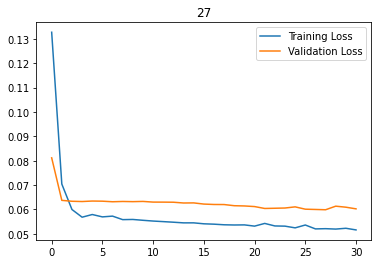

Performance on Test data:
Test RMSE: 0.742
Test MAE: 0.401
Test RMSE period 0: 0.443
Test RMSE period 1: 0.627
Test RMSE period 2: 0.770
Test RMSE period 3: 1.011
Test MAE period 0: 0.224
Test MAE period 1: 0.328
Test MAE period 2: 0.425
Test MAE period 3: 0.629
Test FID: 0.596
iter         27.000000
Epoch        31.000000
TS            8.000000
Dropout       0.300000
Layer1        2.000000
LR            0.001000
KR            0.000000
AR            0.000000
RR            0.000001
uLSTM        64.000000
TrainLoss     0.051592
ValidLoss     0.060238
RMSE          0.742246
MAE           0.401468
Name: 27, dtype: float64


In [49]:
vars = dv
#vars = dv + all_var

# Loop to test parameters
#tss = [2,4,8]
tss = [8]
drops = [0,0.3]
#layers = [1,2,3]
layers = [1,2]
#lrs = [0.001, 0.0001]
lrs = [0.001]
rrs = [[0, 0, 0],
       [0.000100, 0, 0],
       [0, 0.000100, 0],
       [0, 0, 0.000100],
       [0.000001, 0, 0],
       [0, 0.000001, 0],
       [0, 0, 0.000001]]

#lstms = [16, 32, 64, 128]
lstms = [64]
epoch=3000

params = pd.DataFrame()
i=0
for ts in tss:
  #data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
  #  prepare_data(data, vars, val_mths=4, ts=ts)
  for drop in drops:
    for layer1 in layers:
      #for layer2 in layers[-1:]:
          for lr in lrs:
            for rr in rrs:
                  for lstm in lstms:
                    model, history, rmse, mae = run_model_fix(n_epochs=epoch, autoenc=0, n_layers=[layer1,1], lstm_units=lstm, 
                                              lr=lr, drop=drop, n_batch_size=32,
                                              reg=rr, iteri=i)
                    params.loc[i,'iter'] = i
                    params.loc[i,'Epoch'] = len(history.history['loss'])
                    params.loc[i,'TS'] = ts
                    params.loc[i,'Dropout'] = drop
                    params.loc[i,'Layer1'] = layer1
                    #params.loc[i,'Layer2'] = layer2
                    params.loc[i,'LR'] = lr
                    params.loc[i,'KR'] = rr[0]
                    params.loc[i,'AR'] = rr[1]
                    params.loc[i,'RR'] = rr[2]
                    params.loc[i,'uLSTM'] = lstm
                    params.loc[i,'TrainLoss'] = history.history['loss'][-1]
                    params.loc[i,'ValidLoss'] = history.history['val_loss'][-1]
                    params.loc[i,'RMSE'] = rmse
                    params.loc[i,'MAE'] = mae
                    print(params.iloc[i,:])
                    params.to_csv("params.csv")
                    i +=1


## Final Model One Var 0.694 / 0.391

In [15]:
vars = dv
ts=8
n_out=4 # number of leeds to forecast
d_out=4 # number of leeds to forecast
# Create training datasets
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data(data, vars, val_mths=4, ts=ts)

Train:  (53622, 8, 1) 53622
Valid:  (3035, 8, 1) 3035
Test:  (3035, 8, 1) 3035


Epoch 1/3000
1676/1676 - 11s - loss: 0.1059 - val_loss: 0.0737
Epoch 2/3000
1676/1676 - 7s - loss: 0.0607 - val_loss: 0.0629
Epoch 3/3000
1676/1676 - 7s - loss: 0.0558 - val_loss: 0.0627
Epoch 4/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0625
Epoch 5/3000
1676/1676 - 7s - loss: 0.0548 - val_loss: 0.0626
Epoch 6/3000
1676/1676 - 7s - loss: 0.0547 - val_loss: 0.0623
Epoch 7/3000
1676/1676 - 7s - loss: 0.0539 - val_loss: 0.0621
Epoch 8/3000
1676/1676 - 7s - loss: 0.0542 - val_loss: 0.0623
Epoch 9/3000
1676/1676 - 7s - loss: 0.0536 - val_loss: 0.0618
Epoch 10/3000
1676/1676 - 7s - loss: 0.0532 - val_loss: 0.0620
Epoch 11/3000
1676/1676 - 7s - loss: 0.0530 - val_loss: 0.0618
Epoch 12/3000
1676/1676 - 7s - loss: 0.0531 - val_loss: 0.0617
Epoch 13/3000
1676/1676 - 7s - loss: 0.0530 - val_loss: 0.0615
Epoch 14/3000
1676/1676 - 7s - loss: 0.0529 - val_loss: 0.0611
Epoch 15/3000
1676/1676 - 7s - loss: 0.0525 - val_loss: 0.0617
Epoch 16/3000
1676/1676 - 7s - loss: 0.0525 - val_loss: 0.0614


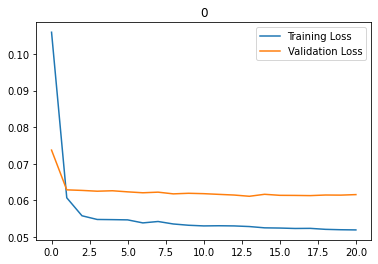

Performance on Test data:
Test RMSE: 0.694
Test MAE: 0.391
Test RMSE period 0: 0.370
Test RMSE period 1: 0.549
Test RMSE period 2: 0.724
Test RMSE period 3: 0.982
Test MAE period 0: 0.211
Test MAE period 1: 0.318
Test MAE period 2: 0.422
Test MAE period 3: 0.613
Test FID: 0.582


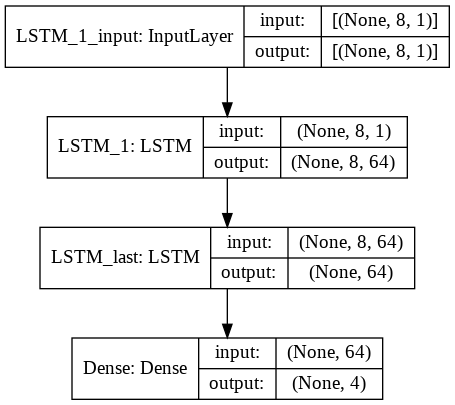

In [53]:
# Univariate model with fixed batch
# Set parameters
model, history, rmse, mae = run_model_fix(n_epochs=3000,
                                              n_layers=[1,1], 
                                              lstm_units=64, 
                                              lr=0.001, 
                                              drop = 0.3,
                                              reg=[0.000001,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

In [54]:
# Save model
model.save('LSTM_OneVar.h5')
# Load model
#model = tf.keras.models.load_model('LSTM_OneVar.h5')

Test RMSE: 0.543
Test RMSE period 0: 0.343
Test RMSE period 1: 0.479
Test RMSE period 2: 0.590
Test RMSE period 3: 0.696


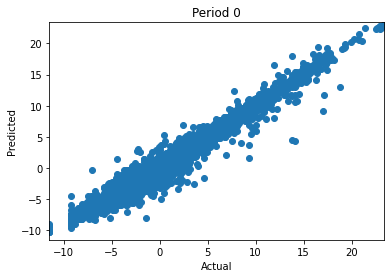

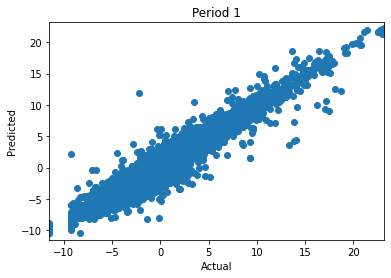

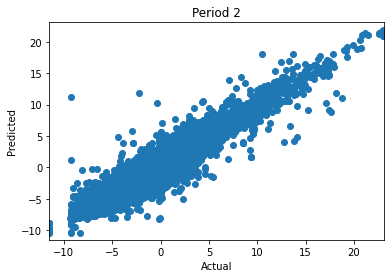

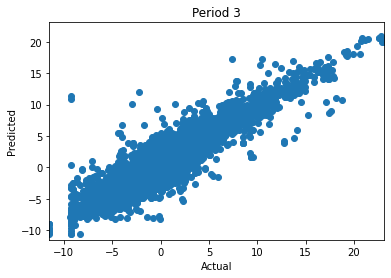

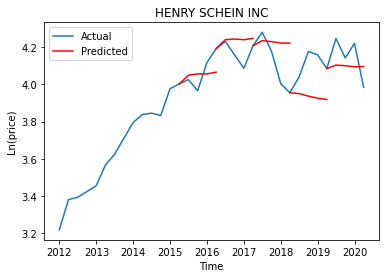

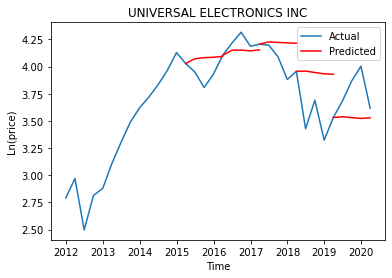

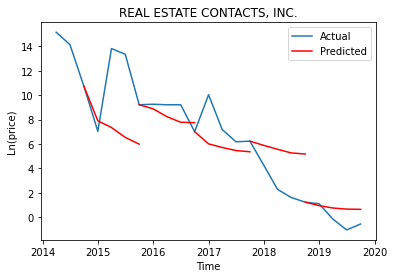

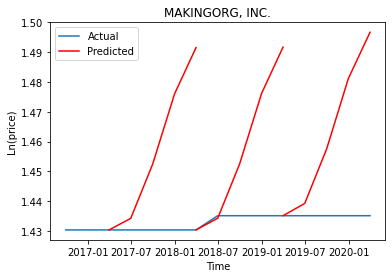

2806    0.08502
Name: dif, dtype: float64
1520    0.202086
Name: dif, dtype: float64
2.582144689461992
0.0035750107039704843


In [55]:
# Forecast
all_lag, y_act, yhat, impt_var, rmse = prediction(model, scalers, importance=0, autoenc=0)
# Plots
# Max/Min differences
ydiff = pd.DataFrame(index = all_lag.index, columns=['dif'])
ydiff['dif'] = (y_act - yhat)**2
ydiff_co = np.sqrt(ydiff.reset_index().groupby('cik').mean('dif'))
ydiff_co = ydiff_co.sort_values(by='dif',ascending=False)
ydiff_co = ydiff_co.reset_index()

# Actual vs Predicted plots
f_yr=5 # number of years for comparison
step=4 # step in quarters
sample_plot(co=companies[0], f_yr=f_yr, step=step)
sample_plot(co=companies[100], f_yr=f_yr, step=step)
sample_plot(co=ydiff_co.iloc[0,0], f_yr=f_yr, step=step) # worst fit
sample_plot(co=ydiff_co.iloc[-1,0], f_yr=f_yr, step=step) # best fit
print(ydiff_co.loc[ydiff_co.cik==companies[0],'dif'])
print(ydiff_co.loc[ydiff_co.cik==companies[100],'dif'])
print(ydiff_co.iloc[0,1])
print(ydiff_co.iloc[-1,1])

In [56]:
# Calculate prediction on test data
yhatt = model.predict(x_test) if autoenc==0 else model.predict(x_test)[:,:,0]
yhatt = scalers[1].inverse_transform(yhatt) # unnormalize
y_actt = scalers[1].inverse_transform(y_test) # unnormalize

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155604 samples in 0.132s...
[t-SNE] Computed neighbors for 155604 samples in 7.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 155604
[t-SNE] Computed conditional probabilities for sample 2000 / 155604
[t-SNE] Computed conditional probabilities for sample 3000 / 155604
[t-SNE] Computed conditional probabilities for sample 4000 / 155604
[t-SNE] Computed conditional probabilities for sample 5000 / 155604
[t-SNE] Computed conditional probabilities for sample 6000 / 155604
[t-SNE] Computed conditional probabilities for sample 7000 / 155604
[t-SNE] Computed conditional probabilities for sample 8000 / 155604
[t-SNE] Computed conditional probabilities for sample 9000 / 155604
[t-SNE] Computed conditional probabilities for sample 10000 / 155604
[t-SNE] Computed conditional probabilities for sample 11000 / 155604
[t-SNE] Computed conditional probabilities for sample 12000 / 155604
[t-SNE] Computed conditional probab

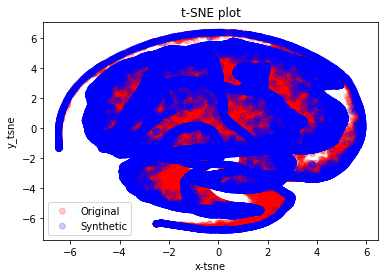

In [57]:
# T-SNE on Full dataset
tSNE_Analysis(y_act, yhat)

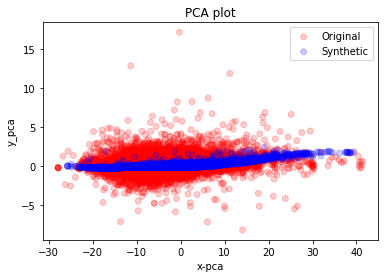

In [58]:
# PCA on Full dataset
PCA_Analysis(y_act, yhat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5870 samples in 0.004s...
[t-SNE] Computed neighbors for 5870 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5870
[t-SNE] Computed conditional probabilities for sample 2000 / 5870
[t-SNE] Computed conditional probabilities for sample 3000 / 5870
[t-SNE] Computed conditional probabilities for sample 4000 / 5870
[t-SNE] Computed conditional probabilities for sample 5000 / 5870
[t-SNE] Computed conditional probabilities for sample 5870 / 5870
[t-SNE] Mean sigma: 0.075498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.729511
[t-SNE] KL divergence after 300 iterations: 1.461973


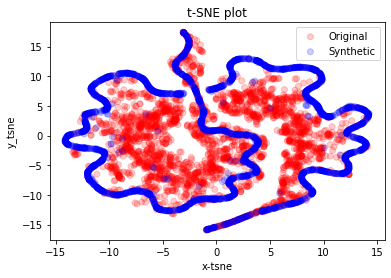

In [59]:
# T-SNE on test dataset
tSNE_Analysis(y_actt, yhatt)

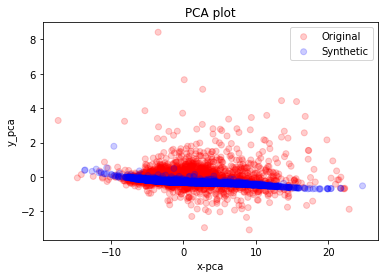

In [60]:
# PCA on test dataset
PCA_Analysis(y_actt, yhatt)

## Final Model All Var 0.775 / 0.472

In [61]:
vars = dv + all_var
ts=8
n_out=4 # number of leeds to forecast
d_out=4 # number of leeds to forecast
# Create training datasets
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data(data, vars, val_mths=4, ts=ts)

Train:  (53622, 8, 408) 53622
Valid:  (3035, 8, 408) 3035
Test:  (3035, 8, 408) 3035


Epoch 1/3000
1676/1676 - 16s - loss: 0.4421 - val_loss: 0.4657
Epoch 2/3000
1676/1676 - 10s - loss: 0.2480 - val_loss: 0.2831
Epoch 3/3000
1676/1676 - 10s - loss: 0.1771 - val_loss: 0.2114
Epoch 4/3000
1676/1676 - 10s - loss: 0.1462 - val_loss: 0.1831
Epoch 5/3000
1676/1676 - 10s - loss: 0.1353 - val_loss: 0.1626
Epoch 6/3000
1676/1676 - 10s - loss: 0.1211 - val_loss: 0.1661
Epoch 7/3000
1676/1676 - 10s - loss: 0.1090 - val_loss: 0.1579
Epoch 8/3000
1676/1676 - 10s - loss: 0.1075 - val_loss: 0.1445
Epoch 9/3000
1676/1676 - 10s - loss: 0.1066 - val_loss: 0.1423
Epoch 10/3000
1676/1676 - 10s - loss: 0.0960 - val_loss: 0.1525
Epoch 11/3000
1676/1676 - 10s - loss: 0.0900 - val_loss: 0.1203
Epoch 12/3000
1676/1676 - 10s - loss: 0.0883 - val_loss: 0.1246
Epoch 13/3000
1676/1676 - 10s - loss: 0.0864 - val_loss: 0.1093
Epoch 14/3000
1676/1676 - 10s - loss: 0.0852 - val_loss: 0.1341
Epoch 15/3000
1676/1676 - 10s - loss: 0.0857 - val_loss: 0.1057
Epoch 16/3000
1676/1676 - 10s - loss: 0.0764 - va

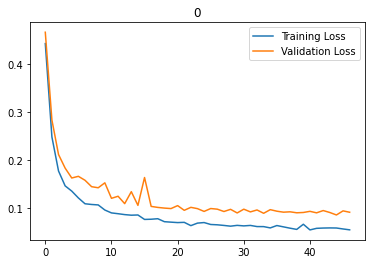

Performance on Test data:
Test RMSE: 0.775
Test MAE: 0.472
Test RMSE period 0: 0.506
Test RMSE period 1: 0.657
Test RMSE period 2: 0.811
Test RMSE period 3: 1.028
Test MAE period 0: 0.333
Test MAE period 1: 0.416
Test MAE period 2: 0.507
Test MAE period 3: 0.633
Test FID: 0.689


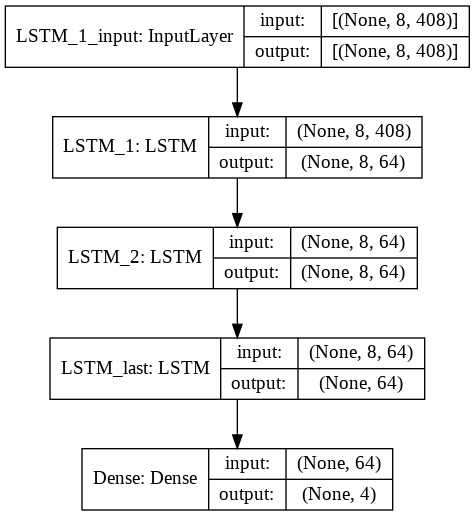

In [67]:
# Run model
model, history, rmse, mae = run_model_fix(n_epochs=3000, drop=0, 
                                              n_layers=[2,1], lstm_units=64, 
                                              lr=0.001, 
                                              reg=[0.0001,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

In [68]:
# Save model
model.save('LSTM_AllVar.h5')
# Load model
#model = tf.keras.models.load_model('LSTM_AllVar.h5')

Test RMSE: 0.548
Test RMSE period 0: 0.435
Test RMSE period 1: 0.503
Test RMSE period 2: 0.572
Test RMSE period 3: 0.656


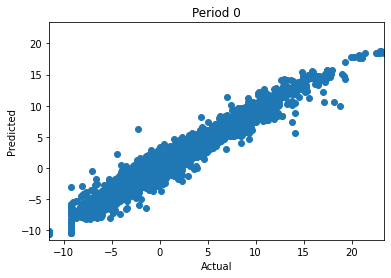

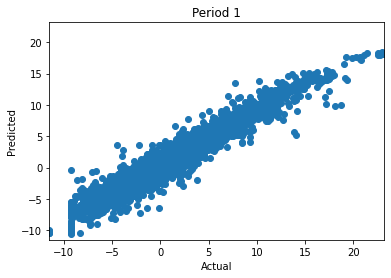

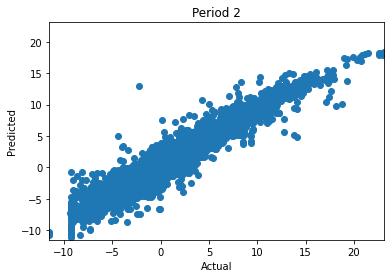

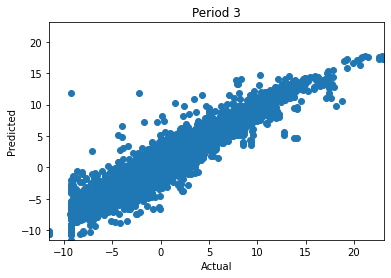

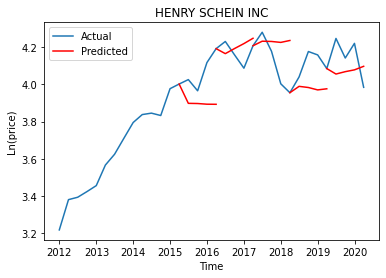

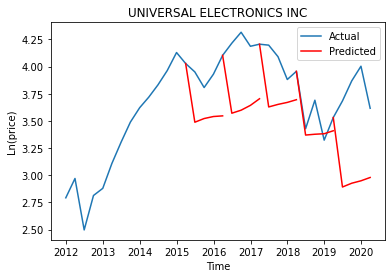

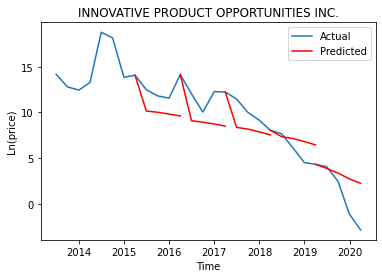

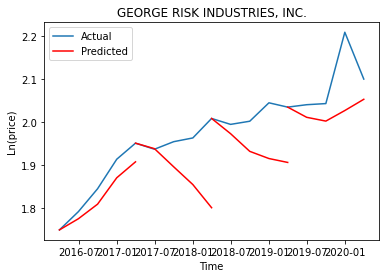

2967    0.094884
Name: dif, dtype: float64
510    0.542861
Name: dif, dtype: float64
3.3124583978141224
0.052705523693294946


In [75]:
# Forecast
all_lag, y_act, yhat, impt_var, rmse = prediction(model, scalers, importance=1, autoenc=0)
# Plots
# Max/Min differences
ydiff = pd.DataFrame(index = all_lag.index, columns=['dif'])
ydiff['dif'] = (y_act - yhat)**2
ydiff_co = np.sqrt(ydiff.reset_index().groupby('cik').mean('dif'))
ydiff_co = ydiff_co.sort_values(by='dif',ascending=False)
ydiff_co = ydiff_co.reset_index()

# Actual vs Predicted plots
f_yr=5 # number of years for comparison
step=4 # step in quarters
sample_plot(co=companies[0], f_yr=f_yr, step=step)
sample_plot(co=companies[100], f_yr=f_yr, step=step)
sample_plot(co=ydiff_co.iloc[0,0], f_yr=f_yr, step=step) # worst fit
sample_plot(co=ydiff_co.iloc[-1,0], f_yr=f_yr, step=step) # best fit
print(ydiff_co.loc[ydiff_co.cik==companies[0],'dif'])
print(ydiff_co.loc[ydiff_co.cik==companies[100],'dif'])
print(ydiff_co.iloc[0,1])
print(ydiff_co.iloc[-1,1])

In [77]:
impt_var.to_csv("impt2_all2.csv")

## Final Model All Imp Var 0.663 / 0.383

In [161]:
vars = dv + ratios + macroec + ['CA','CN','OT','US']
ts=8
n_out=4 # number of leeds to forecast
d_out=4 # number of leeds to forecast
# Create training datasets
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data(data, vars, val_mths=4, ts=ts)


Train:  (53622, 8, 18) 53622
Valid:  (3035, 8, 18) 3035
Test:  (3035, 8, 18) 3035


Epoch 1/3000
1676/1676 - 15s - loss: 0.1819 - val_loss: 0.1236
Epoch 2/3000
1676/1676 - 10s - loss: 0.0925 - val_loss: 0.0772
Epoch 3/3000
1676/1676 - 10s - loss: 0.0715 - val_loss: 0.0690
Epoch 4/3000
1676/1676 - 10s - loss: 0.0649 - val_loss: 0.0647
Epoch 5/3000
1676/1676 - 10s - loss: 0.0635 - val_loss: 0.0629
Epoch 6/3000
1676/1676 - 10s - loss: 0.0609 - val_loss: 0.0623
Epoch 7/3000
1676/1676 - 10s - loss: 0.0608 - val_loss: 0.0620
Epoch 8/3000
1676/1676 - 10s - loss: 0.0593 - val_loss: 0.0616
Epoch 9/3000
1676/1676 - 10s - loss: 0.0593 - val_loss: 0.0614
Epoch 10/3000
1676/1676 - 10s - loss: 0.0575 - val_loss: 0.0610
Epoch 11/3000
1676/1676 - 10s - loss: 0.0560 - val_loss: 0.0607
Epoch 12/3000
1676/1676 - 10s - loss: 0.0574 - val_loss: 0.0607
Epoch 13/3000
1676/1676 - 10s - loss: 0.0564 - val_loss: 0.0599
Epoch 14/3000
1676/1676 - 10s - loss: 0.0537 - val_loss: 0.0599
Epoch 15/3000
1676/1676 - 10s - loss: 0.0536 - val_loss: 0.0600
Epoch 16/3000
1676/1676 - 10s - loss: 0.0540 - va

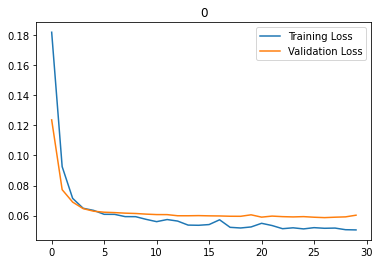

Performance on Test data:
Test RMSE: 0.663
Test MAE: 0.383
Test RMSE period 0: 0.378
Test RMSE period 1: 0.533
Test RMSE period 2: 0.686
Test RMSE period 3: 0.929
Test MAE period 0: 0.227
Test MAE period 1: 0.315
Test MAE period 2: 0.400
Test MAE period 3: 0.590
Test FID: 0.473


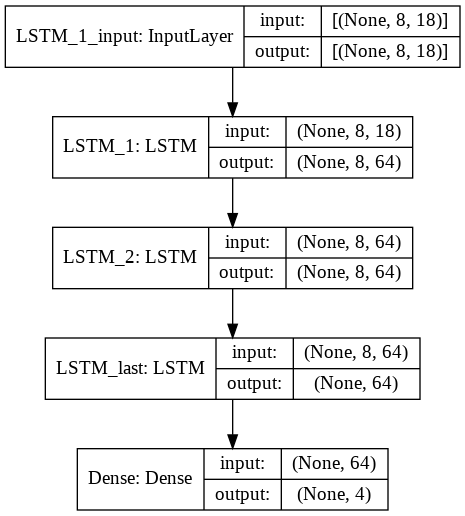

In [162]:
# Run model
model, history, rmse, mae = run_model_fix(n_epochs=3000, drop=0, 
                                              n_layers=[2,1], lstm_units=64, 
                                              lr=0.001, 
                                              reg=[0.0001,0,0])
plot_model(model, show_shapes=True, show_layer_names=True)

In [166]:
# Save model
model.save('LSTM_ImpVar.h5')
# Load model
#model = tf.keras.models.load_model('LSTM_ImpVar.h5')

Test RMSE: 0.519
Test RMSE period 0: 0.360
Test RMSE period 1: 0.462
Test RMSE period 2: 0.557
Test RMSE period 3: 0.651


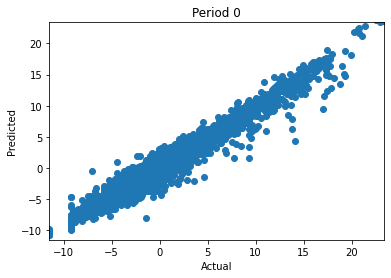

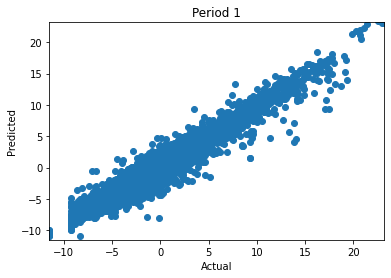

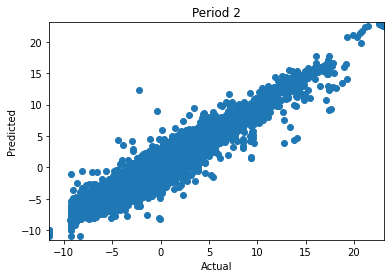

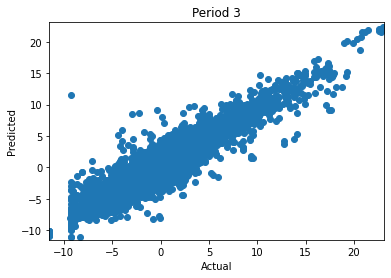

In [177]:
# Forecast
all_lag, y_act, yhat, impt_var, rmse = prediction(model, scalers, importance=1)

In [178]:
impt_var.to_csv("impt2_all.csv")

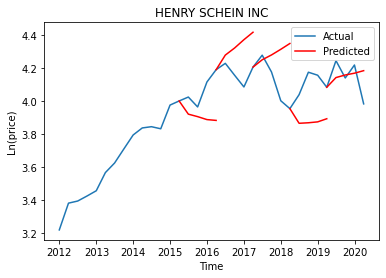

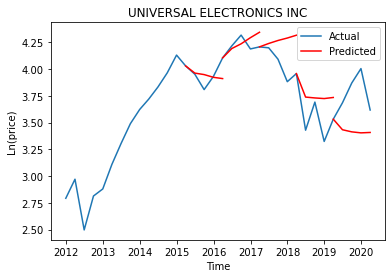

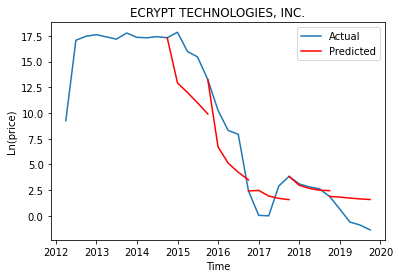

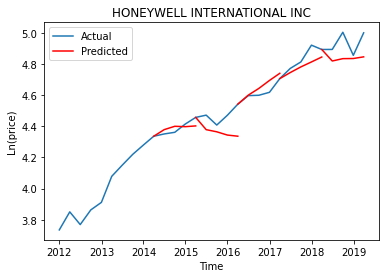

2680    0.118342
Name: dif, dtype: float64
1671    0.199299
Name: dif, dtype: float64
2.69960838682518
0.06522693398845072


In [179]:
# Plots
# Max/Min differences
ydiff = pd.DataFrame(index = all_lag.index, columns=['dif'])
ydiff['dif'] = (y_act - yhat)**2
ydiff_co = np.sqrt(ydiff.reset_index().groupby('cik').mean('dif'))
ydiff_co = ydiff_co.sort_values(by='dif',ascending=False)
ydiff_co = ydiff_co.reset_index()

# Actual vs Predicted plots
f_yr=5 # number of years for comparison
step=4 # step in quarters
sample_plot(co=companies[0], f_yr=f_yr, step=step)
sample_plot(co=companies[100], f_yr=f_yr, step=step)
sample_plot(co=ydiff_co.iloc[0,0], f_yr=f_yr, step=step) # worst fit
sample_plot(co=ydiff_co.iloc[-1,0], f_yr=f_yr, step=step) # best fit
print(ydiff_co.loc[ydiff_co.cik==companies[0],'dif'])
print(ydiff_co.loc[ydiff_co.cik==companies[100],'dif'])
print(ydiff_co.iloc[0,1])
print(ydiff_co.iloc[-1,1])

In [180]:
yhatt = model.predict(x_test) if autoenc==0 else model.predict(x_test)[:,:,0]
yhatt = scalers[1].inverse_transform(yhatt) # unnormalize
y_actt = scalers[1].inverse_transform(y_test) # unnormalize

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155604 samples in 0.126s...
[t-SNE] Computed neighbors for 155604 samples in 7.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 155604
[t-SNE] Computed conditional probabilities for sample 2000 / 155604
[t-SNE] Computed conditional probabilities for sample 3000 / 155604
[t-SNE] Computed conditional probabilities for sample 4000 / 155604
[t-SNE] Computed conditional probabilities for sample 5000 / 155604
[t-SNE] Computed conditional probabilities for sample 6000 / 155604
[t-SNE] Computed conditional probabilities for sample 7000 / 155604
[t-SNE] Computed conditional probabilities for sample 8000 / 155604
[t-SNE] Computed conditional probabilities for sample 9000 / 155604
[t-SNE] Computed conditional probabilities for sample 10000 / 155604
[t-SNE] Computed conditional probabilities for sample 11000 / 155604
[t-SNE] Computed conditional probabilities for sample 12000 / 155604
[t-SNE] Computed conditional probab

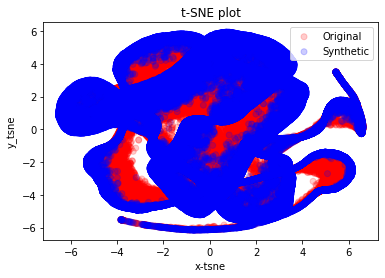

In [186]:
tSNE_Analysis(y_act, yhat)

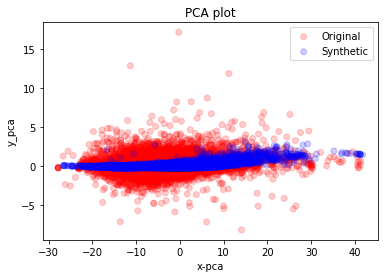

In [182]:
PCA_Analysis(y_act, yhat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5870 samples in 0.003s...
[t-SNE] Computed neighbors for 5870 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5870
[t-SNE] Computed conditional probabilities for sample 2000 / 5870
[t-SNE] Computed conditional probabilities for sample 3000 / 5870
[t-SNE] Computed conditional probabilities for sample 4000 / 5870
[t-SNE] Computed conditional probabilities for sample 5000 / 5870
[t-SNE] Computed conditional probabilities for sample 5870 / 5870
[t-SNE] Mean sigma: 0.089703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.402351
[t-SNE] KL divergence after 300 iterations: 1.469924


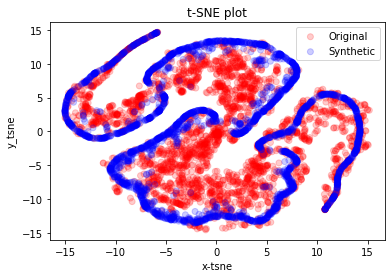

In [187]:
tSNE_Analysis(y_actt, yhatt)

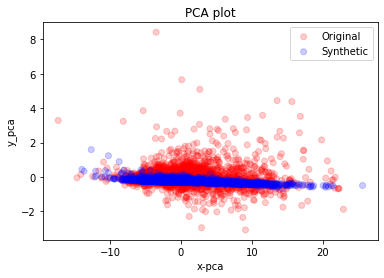

In [185]:
PCA_Analysis(y_actt, yhatt)